# Housekeeping:

In [2]:
sessionInfo()
options(repr.plot.width=14,repr.plot.antialias='subpixel',repr.plot.res=218)
update.packages()

R version 4.0.3 Patched (2020-10-12 r79333)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] compiler_4.0.3  ellipsis_0.3.1  IRdisplay_0.7.0 pbdZMQ_0.3-3   
 [5] tools_4.0.3     htmltools_0.5.0 pillar_1.4.6    base64enc_0.1-3
 [9] crayon_1.3.4    uuid_0.1-4      IRkernel_1.1.1  jsonlite_1.7.1 
[13] digest_0.6.25   lifecycle_0.2.0 repr_1.1.0      rlang_0.4.8    
[17] evaluate_0.14  

# Back to OJ

In [3]:
oj <- read.csv("oj.csv")

A log-log regression to get at elasiticities:

In [4]:
basefit <- lm(log(sales) ~ log(price), data=oj)
coef(basefit)

(Intercept)  log(price) 
  10.423422   -1.601307

Controlling for brands in OLS:

In [5]:
brandfit <- lm(log(sales) ~ brand + log(price), data=oj)
coef(brandfit)

(Intercept) brandminute.maid   brandtropicana       log(price) 
      10.8288216        0.8701747        1.5299428       -3.1386914

Residulaiziing to show what partialing out things mean:

In [6]:
pricereg <- lm(log(price) ~ brand, data=oj)
phat <- predict(pricereg, newdata=oj)
presid <- log(oj$price)-phat
coef( residfit <- lm( log(sales) ~ presid, data=oj) )

(Intercept)      presid 
   9.167864   -3.138691

We get the same coefficient on the residual or the original variable if we control for the predicted value:

In [7]:
residfit2 <- lm( log(sales) ~ phat + log(price), data=oj)
coef(residfit2)

(Intercept)        phat  log(price) 
   9.262685    3.017759   -3.138691

Traditionally, and for consistency, you would also residualize the left-hand side when you residualize the right-hand size. (You can also Google the Frisch-Waugh-Lowell Theorem. Frisch also shared the first Nobel Prize in economics.)

In [8]:
salesreg <- lm(log(sales) ~ brand, data=oj)
shat <- predict(salesreg, newdata=oj)
sresid <- log(oj$sales) - shat
residfit3 <- lm( sresid ~ presid - 1)
coef(residfit3)

presid 
-3.138691

# Not controling for abortion

Let's turn to a famous line of research, earning Levitt a Clark Medal (also Google Melissa Dell) and the Freakonomics franchise.

For this, let's load some data that is not in comma-separated plain text (csv) this time.

(`skip` says 'skip the first line of the file', `sep="/t"` says 'tab separated')

In [9]:
data <- read.table("abortion.dat", skip=1, sep="\t")
names(data) <- c("state","year","pop","y_viol","y_prop","y_murd",
	"a_murd","a_viol","a_prop",'prison','police',
	'ur','inc','pov','afdc','gun','beer')

Some variable descriptions:

* prison: log of lagged prisoners per capita
* police: the log of lagged police per capita
* ur: the unemployment rate
* inc: per-capita income
* pov: the poerty rate
* AFDC: generosity at year t-15
* gun: dummy for concealed weapons law
* beer: beer consumption per capita 

Let's drop some unusable parts of the data, and make the time and state variables

In [10]:
data <- data[!(data$state%in%c(2,9,12)),] # AK, DC, HA are strange places
data <- data[data$year>84 & data$year<98,] # incomplete data outside these years
data$pop <- log(data$pop)
t <- data$year - 85
s <- factor(data$state) ## the states are numbered alphabetically

Here come the designated controls:

In [11]:
controls <- data.frame(data[,c(3,10:17)])

Key: `y` is de-trended log crime rate, criminal-age-weighted prior abortion rate `a` is as described below. Note we also have violent and property crime versions for both.

In [12]:
y <- data$y_murd
d <- data$a_murd

The abortion `a_` variables are weighted average of abortion rates where weights are determined by the fraction of the type of crime committed by various age groups. For example, if 60% of violent crime were committed by 18-year-olds and 40% were committed by 19 year olds in state `i`, the abortion rate for violent crime at time `t` in state `i` would be constructed as `.6` times the abortion rate in state `i` at time `t − 18` plus `.4` times the abortion rate in state `i` at time `t − 19`. See Donohue and Levitt (2001) for further detail.

We'll just look at murder. 
Note that for convenience here we've made `y,d,t` global: they are not in `controls`.

Let's win a Clark Medal:

In [13]:
summary(orig <- glm(y ~ d + t + s +., data=controls) )$coef['d',]

Estimate    Std. Error       t value      Pr(>|t|) 
-2.098119e-01  4.109177e-02 -5.105936e+00  4.505925e-07

That abortion is only one factor influencing crime in the late 1980s points out the caution required in drawing any conclusions regarding an abortion-crime link based on time series evidence alone.

As a cautionary example, let's repeat the analysis, but for cellphones rather than abortion:

In [14]:
cell <- read.csv("us_cellphone.csv")
cellrate <- 5*cell[,2]/(1000*cell[,3]) # center on 1985 and scale by 1997-1985

A smart observation: there are many things that increased with similar (but non-linear) shapes over time (cellphone usage, yoga revenues, home prices, ...). Is this loading onto abortion? What if we're just fitting a quadratic trend?

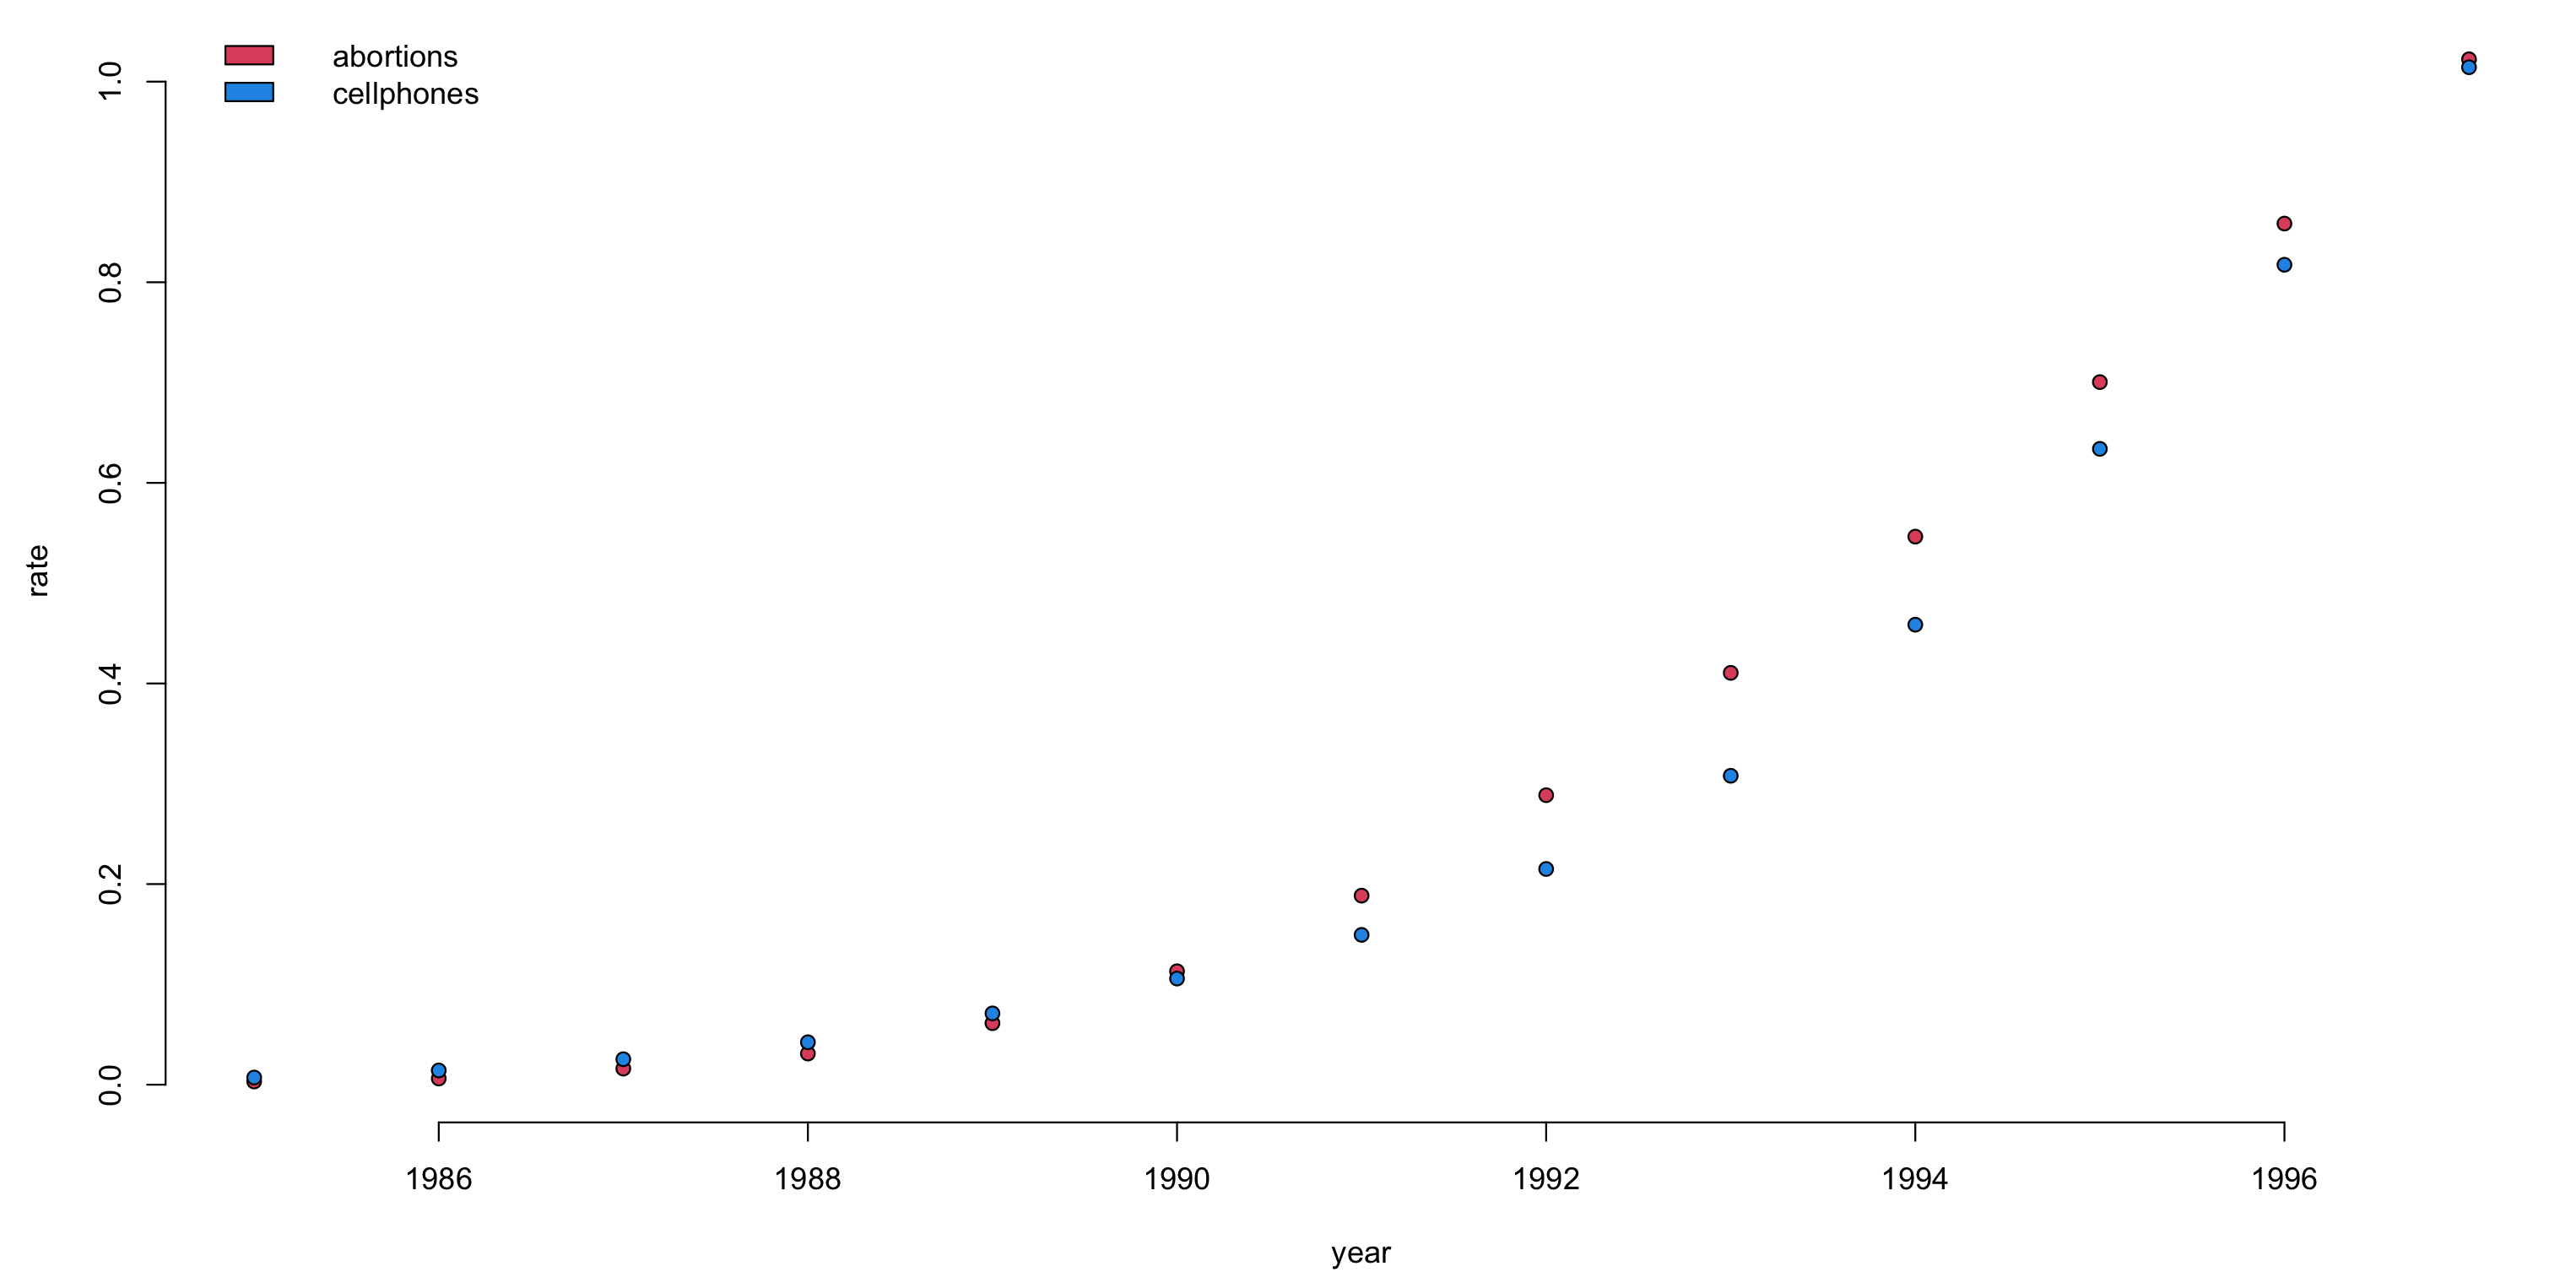

In [15]:
par(mai=c(.9,.9,.1,.1))
plot(1985:1997, tapply(d, t, mean), bty="n", xlab="year", ylab="rate", pch=21, bg=2)
points(1985:1997, cellrate, bg=4, pch=21)
legend("topleft", fill=c(2,4), legend=c("abortions","cellphones"), bty="n")

In [16]:
phone <- cellrate[t+1]
summary(tech <- glm(y ~ phone + s + t+., data=controls))$coef['phone',]
1 - exp(-3.72e-01)

Estimate    Std. Error       t value      Pr(>|t|) 
-3.720723e-01  6.932262e-02 -5.367257e+00  1.168637e-07

[1] 0.3106458

What is happening here is that murder has been increasing quadratically, and we have no other controls that do so.  To be correct, you need to allow quadratic trends that could be caused by other confounding variables (e.g. technology).
We also allow interaction between the controls, and interact the nation-wide phone variable with state dummies to allow for state specific tech adoption.

In [17]:
t <- factor(t)
interact <- glm(y ~ d + t + phone*s + .^2, data=controls)
summary(interact)$coef["d",]

Estimate Std. Error    t value   Pr(>|t|) 
 0.2797107  0.1807311  1.5476619  0.1223753

The abortion effect has switched direction (and is insignificant)!

But we have very few observations relative to number of parameters:

In [18]:
dim(model.matrix(formula(interact), data=controls))

[1] 624 154

So we need a way to select only important controls. Try using a lasso (after refactoring state to have NA reference level):

In [19]:
library(gamlr)
sna <- factor(s, levels=c(NA,levels(s)), exclude=NULL)
x = sparse.model.matrix( ~ t + phone*sna + .^2, data=controls)[,-1]
dim(x)

## naive lasso regression
naive <- cv.gamlr(cbind(d,x),y)
coef(naive)["d",] # effect is CV selected <0

Loading required package: Matrix



[1] 624 154

[1] -0.1189633

To explicitly include confounder `dhat` confound, we first need a model to predict treatment (this is step `i` of Algorithm 14):

In [20]:
treat <- cv.gamlr(x,d, lmr=1e-4)

Save the predicted treatment. `type="response"` is redundant here (Gaussian model), but you'd want it if `d` was binary

In [21]:
dhat <- drop( predict(treat, x, select="min") )

Worrying sign: not much signal in `d` not predicted by `dhat` (that means we have little to resemble an experiment here...)

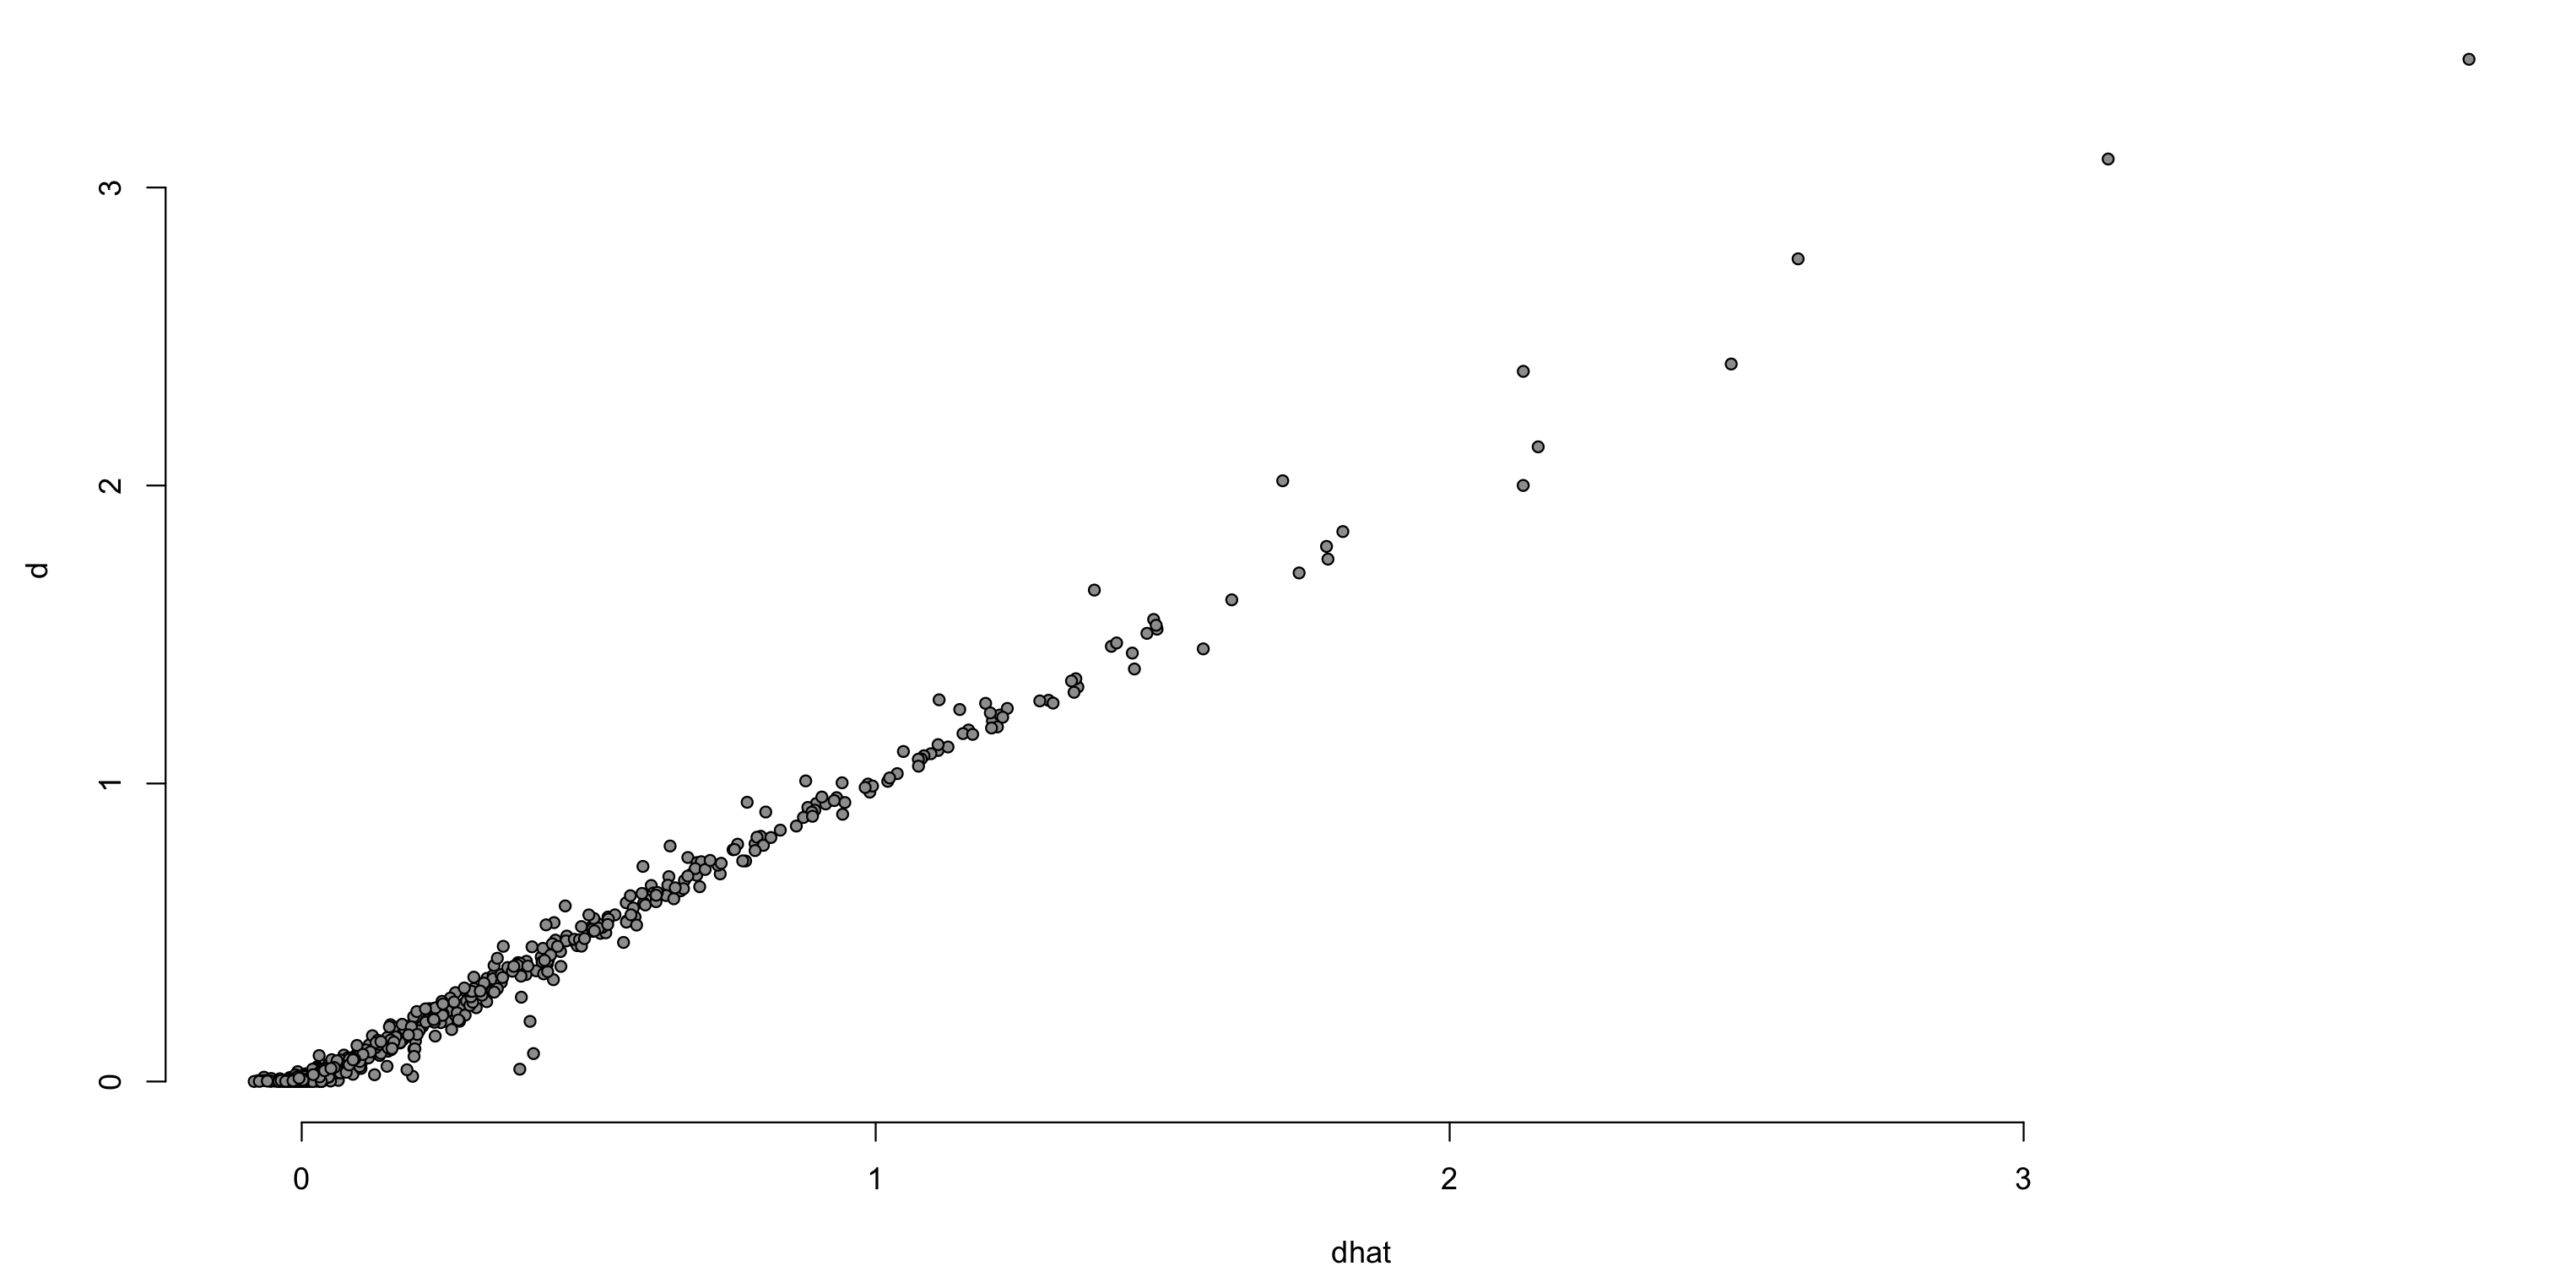

In [22]:
par(mai=c(.9,.9,.1,.1))
plot(dhat,d,bty="n",pch=21,bg=8, cex=.8, yaxt="n")
axis(2, at=c(0,1,2,3)) 

Check an In Sample R^2, which is what governs how much independent signal you have for estimating (which you see in the very similar OLS regressions below)

In [23]:
cor(drop(dhat),d)^2

[1] 0.9896173

In [24]:
summary( glm( y ~ I(d-dhat) ) )
summary( glm( y ~ d + dhat) )


Call:
glm(formula = y ~ I(d - dhat))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.5530  -0.4548   0.0899   0.5427   1.2888  

Coefficients:
            Estimate Std. Error  t value Pr(>|t|)    
(Intercept) -2.87706    0.02626 -109.572   <2e-16 ***
I(d - dhat)  0.32530    0.55353    0.588    0.557    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.4302084)

    Null deviance: 267.74  on 623  degrees of freedom
Residual deviance: 267.59  on 622  degrees of freedom
AIC: 1248.5

Number of Fisher Scoring iterations: 2



Call:
glm(formula = y ~ d + dhat)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.5476  -0.4438   0.0784   0.5415   1.3061  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -2.9080     0.0321 -90.601   <2e-16 ***
d             0.3164     0.5528   0.572    0.567    
dhat         -0.2218     0.5562  -0.399    0.690    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.4289767)

    Null deviance: 267.74  on 623  degrees of freedom
Residual deviance: 266.39  on 621  degrees of freedom
AIC: 1247.7

Number of Fisher Scoring iterations: 2


Properly following Algorithm 14, we can re-run the lasso, with this prediction (the second column) included unpenalized.

In [25]:
causal <- gamlr(cbind(d,dhat,x),y,free=2,lmr=1e-3)
coef(causal)["d",] # AICc says abortion has no causal effect.

[1] 0

Jumping ahead to other methods in the chapter, let's try orthoML on the abortion data.
(with only 5 folds, the results are a bit unstable, but at least it does not matter for the signifiance of the effect)

In [26]:
source("orthoML.R")
dreg <- function(x,d){ cv.gamlr(x, d, lmr=1e-5) }

yreg <- function(x,y){ cv.gamlr(x, y, lmr=1e-5) }

resids <- orthoPLTE( x=x, d=d, y=y, 
				dreg=dreg, yreg=yreg, nfold=5)

Loading required package: AER

Loading required package: car

Loading required package: carData

Loading required package: lmtest

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich

Loading required package: survival



fold: 1  2  3  4  5  
gamma (se) = 0.0180822 (0.147449)


Traditional two-sided p-value for the key treatment effect:

In [27]:
2*(1-pnorm(0.120546/0.164335))

[1] 0.4632302

# Sample-splitting and orthoML in the hockey data

In [28]:
library(gamlr) # loads Matrix as well
data(hockey) # load the data
x <- cbind(config,team,player) # Combine the covariates all together
y <- goal$homegoal # build 'y': home vs away, binary response
fold <- sample.int(2,nrow(x),replace=TRUE)
nhlprereg <- gamlr(x[fold==1,], y[fold==1],
	free=1:(ncol(config)+ncol(team)), 
	family="binomial", standardize=FALSE)

We can just take the selected variables (without the intercept, thus the `-1`), and fit an unpenalized model using them in the other half of the data.

In [29]:
selected <- which(coef(nhlprereg)[-1,] != 0)
xnotzero <- as.data.frame(as.matrix(x[,selected]))
nhlmle <- glm( y ~ ., data=xnotzero, 
			subset=which(fold==2), family=binomial )

We can then interpret the coefficients and the (robust!) standard errors as causally.

In [30]:
x[1,x[1,]!=0]
p <- predict(nhlmle, xnotzero[1,,drop=FALSE], type="response", se.fit=TRUE)
p$fit
p$se.fit
library(AER)
Vnhl <- vcovHC(nhlmle)

DAL.20022003    EDM.20022003     ERIC_BREWER   JASON_CHIMERA      ROB_DIMAIO 
             -1               1               1               1              -1 
 DERIAN_HATCHER    NIKO_KAPANEN   JERE_LEHTINEN JUSSI_MARKKANEN  JANNE_NIINIMAA 
             -1              -1              -1               1               1 
     RYAN_SMYTH   BRIAN_SWANSON     MARTY_TURCO    SERGEI_ZUBOV 
              1               1              -1              -1

Warning message in predict.lm(object, newdata, se.fit, scale = residual.scale, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


1 
0.5059825

1 
0.06894601

Why did we get different numbers from the book? Could the random fold matter this much? Not really. Note that we use the original hockey specification here, when we don't penalize the configuration and team dummies. The book uses the slightly simpler example. (It is a bit surprising it matters this much.)

Let's pick a player as an example:

In [31]:
WHO <- "SIDNEY_CROSBY"
Bhat <- coef(nhlmle)
exp(Bhat["SIDNEY_CROSBY"])
who <- grep(WHO,colnames(x))

SIDNEY_CROSBY 
      1.60205

We can repeat the propensity adjustment exercise:

In [ ]:
treatreg <- gamlr(x[,-who], x[,who], 
				free=1:(ncol(config)+ncol(team)), 
				standardize=FALSE, lmr=1e-6)
plot(treatreg) # basically we're getting OLS here; signal is strong

In [33]:
dhat <- predict(treatreg, x[,-who], type="response")
causereg <- gamlr(cbind(config,team,dhat,player), y, 
				free=1:(ncol(config)+ncol(team)+1), 
				family="binomial", standardize=FALSE)
coef(causereg)[WHO,]

[1] 1.117994

Or just stick to ortogonal ML:

In [34]:
source("orthoML.R")
dreg <- function(x,d){ 
	gamlr(x, d, standardize=FALSE, lmr=1e-5) }

yreg <- function(x,d){ 
	gamlr(x, d, family="binomial", standardize=FALSE, lmr=1e-5) }

resids <- orthoPLTE( x=x[,-who], d=x[,who], y=y, 
				dreg=dreg, yreg=yreg, nfold=5)

fold: 1  2  3  4  5  
gamma (se) = 0.255991 (0.0206741)


# Heterogenous Treatment Effects

Back to the Oregon data:

In [35]:
library(foreign)

descr <- read.dta("OHIE_Public_Use_Files/OHIE_Data/oregonhie_descriptive_vars.dta")
prgm <- read.dta("OHIE_Public_Use_Files/OHIE_Data/oregonhie_stateprograms_vars.dta")
s12 <- read.dta("OHIE_Public_Use_Files/OHIE_Data/oregonhie_survey12m_vars.dta")

# nicely organized, one row per person
all(s12$person_id == descr$person_id)
all(s12$person_id == prgm$person_id)

P <- descr[,c("person_id","household_id", "numhh_list")]
P$medicaid <- as.numeric(prgm[,"ohp_all_ever_firstn_30sep2009"]=="Enrolled")
P$selected <- as.numeric(descr[,"treatment"]=="Selected")
levels(P$numhh_list) <- c("1","2","3+")

# 12 month is the survey that really matters
# need to control for household size interacted with survey return time
Y <- s12[,c("weight_12m",
	"doc_any_12m","doc_num_mod_12m",
	"er_any_12m","er_num_mod_12m",
	"hosp_any_12m","hosp_num_mod_12m")]
Y$doc_any_12m <- as.numeric(Y$doc_any_12m=="Yes")
Y$er_any_12m <- as.numeric(Y$er_any_12m=="Yes")
Y$hosp_any_12m <- as.numeric(Y$hosp_any_12m=="Yes")

# smk_ever_12m - num19_12m are sources of heterogeneity, plus descr
X <- s12[,121:147]
X$dt_returned <- factor(format(s12$dt_returned_12m, "%Y-%m"))

insurv <- which(s12$sample_12m_resp == "12m mail survey responder")
X <- X[insurv,]
Y <- Y[insurv,]
P <- P[insurv,]

sapply(Y,function(y) sum(is.na(y)))
nomiss <- which( !apply(Y,1, function(y) any(is.na(y))) )
X <- X[nomiss,]
Y <- Y[nomiss,]
P <- P[nomiss,]

# pull out the weights and attach doc_any to P
weights <- Y[,1]
Y <- Y[,-1]

# replace some ridiculous values in survey and drop num19
X$hhsize_12m[X$hhsize_12m>10] <- 10
X$num19_12m <- NULL

# organize to make it pretty for text
P$doc_any_12m <- Y$doc_any_12m # you can explore other responses if you want
P <- P[,c(1,2,6,5,4,3)]
names(P)[6] <- "numhh"

[1] TRUE

[1] TRUE

weight_12m      doc_any_12m  doc_num_mod_12m       er_any_12m 
               0              249              300              227 
  er_num_mod_12m     hosp_any_12m hosp_num_mod_12m 
             260              168              202

## Dealing with missingness
As often, make NA the reference level for all categories

In [36]:
source("naref.R")
X <- naref(X)

Now take the numeric variables, flag them when they are missing, and impute zero for sparse variables and means for dense ones.

In [37]:
xnum <- X[,sapply(X,class)%in%c("numeric","integer")]
xnum[66:70,]
colSums(is.na(xnum))
# flag missing
xnumna <- apply(is.na(xnum), 2, as.numeric)
xnumna[66:70,]
# impute the missing values
mzimpute <- function(v){ 
	if(mean(v==0,na.rm=TRUE) > 0.5) impt <- 0
	else impt <- mean(v, na.rm=TRUE)
	v[is.na(v)] <- impt
	return(v) }
xnum <- apply(xnum, 2,  mzimpute)
xnum[66:70,]

# replace/add the variables in new data frame 
for(v in colnames(xnum)){
	X[,v] <- xnum[,v]
	X[,paste(v,"NA", sep=".")] <- xnumna[,v] }
X[144:147,]

,smk_avg_mod_12m,birthyear_12m,hhinc_pctfpl_12m,hhsize_12m
,<int>,<int>,<dbl>,<dbl>
66,0,1974,NA,NA
67,15,1963,150.04617,1
68,NA,1962,150.04617,1
69,20,1964,61.44183,3
70,10,NA,14.71825,10


smk_avg_mod_12m    birthyear_12m hhinc_pctfpl_12m       hhsize_12m 
            3356              518             2253             1175

smk_avg_mod_12m,birthyear_12m,hhinc_pctfpl_12m,hhsize_12m
0,0,1,1
0,0,0,0
1,0,0,0
0,0,0,0
0,1,0,0


smk_avg_mod_12m,birthyear_12m,hhinc_pctfpl_12m,hhsize_12m
0,1974.000,77.20707,2.987188
15,1963.000,150.04617,1.000000
0,1962.000,150.04617,1.000000
20,1964.000,61.44183,3.000000
10,1965.777,14.71825,10.000000


,smk_ever_12m,smk_curr_12m,smk_avg_mod_12m,smk_quit_12m,female_12m,birthyear_12m,employ_12m,employ_det_12m,employ_hrs_12m,hhinc_cat_12m,⋯,live_parents_12m,live_relatives_12m,live_friends_12m,live_other_12m,hhsize_12m,dt_returned,smk_avg_mod_12m.NA,birthyear_12m.NA,hhinc_pctfpl_12m.NA,hhsize_12m.NA
,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
144,No,not at all,0,NA,Male,1983,Yes,"Yes, employed",NA,NA,⋯,No,No,No,No,2.987188,2009-07,0,0,1,1
145,Yes,every day,14,No,Male,1966,NA,NA,work <20 hrs/week,$5001-$7500,⋯,No,Yes,No,Yes,5.000000,2009-09,0,0,0,0
146,Yes,every day,6,Yes,Female,1961,Yes,"Yes, employed",work <20 hrs/week,$10001-$12500,⋯,No,No,Yes,No,3.000000,2009-09,0,0,0,0
147,Yes,not at all,0,NA,Female,1960,Yes,"Yes, employed",work 30+ hrs/week,NA,⋯,No,No,No,No,4.000000,2009-09,0,0,1,0


Now we just build the usual design matrix.

In [38]:
xhte <- sparse.model.matrix(~., data=cbind(numhh=P$numhh, X))[,-1]
xhte[1:2,1:4]
dim(xhte)

2 x 4 sparse Matrix of class "dgCMatrix"
  numhh2 numhh3+ smk_ever_12mNo smk_ever_12mYes
1      .       .              .               1
2      .       .              1               .

[1] 23107    91

And interactions for an even larger design matrix:

In [39]:
dxhte <- P$selected*xhte
colnames(dxhte) <- paste("d",colnames(xhte), sep=".")
htedesign <- cbind(xhte,d=P$selected,dxhte)

And now we can fix the interacted model, only we need to include the baseline treatment and its  `numhh` controls without penalty.

In [40]:
htefit <- gamlr(x=htedesign, y=P$doc_any_12m, free=c("numhh2","numhh3+","d"))
gam <- coef(htefit)[-(1:(ncol(xhte)+1)), ]
round(sort(gam)[1:6],4)
round(sort(gam, decreasing=TRUE)[1:6],4)

[1]  1  2 92


d.race_asian_12mYes d.employ_hrs_12mwork 20-29 hrs/week 
                            -0.0446                             -0.0433 
       d.hhinc_cat_12m$32501-$35000        d.hhinc_cat_12m$27501-$30000 
                            -0.0293                             -0.0232 
       d.hhinc_cat_12m$15001-$17500                  d.race_hisp_12mYes 
                            -0.0195                             -0.0173

d      d.race_pacific_12mYes 
                    0.0927                     0.0404 
d.hhinc_cat_12m$2501-$5000 d.hhinc_cat_12m$5001-$7500 
                    0.0221                     0.0137 
       d.live_other_12mYes        d.race_black_12mYes 
                    0.0116                     0.0067

There is one extra complication here: as the interacting variables don't average to a zero shift of the treatment effect, the ATE is not just the coefficient on the `d` variable but also the weighted some of the heterogenous treatment effects. They can be collected by hand, or with a shorthand that certainly takes some time to learn.

In [41]:
gam["d"] + colMeans(xhte)%*%gam[grep("d.", names(gam))]

0.05616546


# Hold my beer

Load, explore and downsample the (cleaned) Dominick's beer data:

In [42]:
load("dominicks-beer.rda")

# how many upcs?
length( upctab <- table(wber$UPC) )

# check data types
sapply(wber, class)

# create priceperoz
wber$lp <- log(12*wber$PRICE/upc[wber$UPC,"OZ"])

# smallbeer
set.seed(888)
ss <- sample.int(nrow(wber),5e3)

[1] 287

STORE         UPC        WEEK       PRICE        MOVE 
"character" "character"    "factor"   "numeric"   "integer"

See how you can get a small elasticity:

In [43]:
coef( margfit <- lm(log(MOVE) ~ lp, data=wber[ss,]) )

(Intercept)          lp 
  1.0460866  -0.6582606

Now, we better have some controls. Say, dummy indicators for beer type, week, and store:

In [44]:
wber$s <- factor(wber$STORE)
wber$u <- factor(wber$UPC)
wber$w <- factor(wber$WEEK)
xs <- sparse.model.matrix( ~ s-1, data=wber)
xu <- sparse.model.matrix( ~ u-1, data=wber)
xw <- sparse.model.matrix( ~ w-1, data=wber)

We'll also collect some indicators for words in the description, and collect all controls:

In [45]:
#install.packages("tm")
library(tm)
descr <- Corpus(VectorSource(as.character(upc$DESCRIP)))
descr <- DocumentTermMatrix(descr)
descr <- sparseMatrix(i=descr$i,j=descr$j,x=as.numeric(descr$v>0), # convert from stm to Matrix format
              dims=dim(descr),dimnames=list(rownames(upc),colnames(descr)))

descr[1:5,1:6]
descr[287,descr[287,]!=0]

controls <- cbind(xs, xu, xw, descr[wber$UPC,]) 
dim(controls)

Loading required package: NLP



5 x 6 sparse Matrix of class "dgCMatrix"
           32oz beer budweiser n.r.b 6pk busch
1820000008    1    1         1     1   .     .
1820000016    .    1         1     .   1     .
1820000051    .    1         .     .   1     1
1820000106    .    1         1     .   1     .
1820000117    1    1         1     .   .     .

6pk    red    ale  honey oregon 
     1      1      1      1      1

[1] 1600572     851

Here's the naive lasso. (Why don't we standardize here?)

In [46]:
naivefit <- gamlr(x=cbind(lp=wber$lp,controls)[ss,], y=log(wber$MOVE)[ss], free=1, standardize=FALSE)
print( coef(naivefit)[1:2,] )

intercept        lp 
 0.128270 -1.980717 


Let's do the double/orthogonal ML:

In [47]:
source("orthoML.R")
dreg <- function(x,d){ 
	gamlr(x, d, standardize=FALSE, lmr=1e-5) }

yreg <- function(x,y){ 
	gamlr(x, y, standardize=FALSE, lmr=1e-5) }

resids <- orthoPLTE( x=controls[ss,], d=wber$lp[ss], y=log(wber$MOVE)[ss], dreg=dreg, yreg=yreg, nfold=5)

fold: 1  2  3  4  5  
gamma (se) = -3.60396 (0.121278)


Now here's a new trick: Actually, we can fit a big model after all, without penalty, but we would still need these fancy commands. Why? Because the standard commands work with matrices, which are horrendously large here if you want to include all the zeros everywhere. So let's you a trusty command that works with sparse matrices, only without penalties this time.

In [48]:
fullfit <- gamlr(x=cbind(lp=wber$lp,controls), y=log(wber$MOVE), lambda.start=0)
print( coef(fullfit)["lp",] )

[1] -3.567488


Heterogenous treatment effects are great for beer, but complicated to build.

In [49]:
# interact items and text with price
lpxu <- xu*wber$lp
colnames(lpxu) <- paste("lp",colnames(lpxu),sep="")
# create our interaction matrix
xhte <- cbind(BASELINE=1,descr[wber$UPC,])
d <- xhte*wber$lp
colnames(d) <- paste("lp",colnames(d),sep=":")

eachbeer <- xhte[match(rownames(upc),wber$UPC),]
rownames(eachbeer) <- rownames(upc)

Use these interactions in the fanciest model first:

[1] -0.001725252 -2.836513198

[1] -8.4362825 -0.5210011

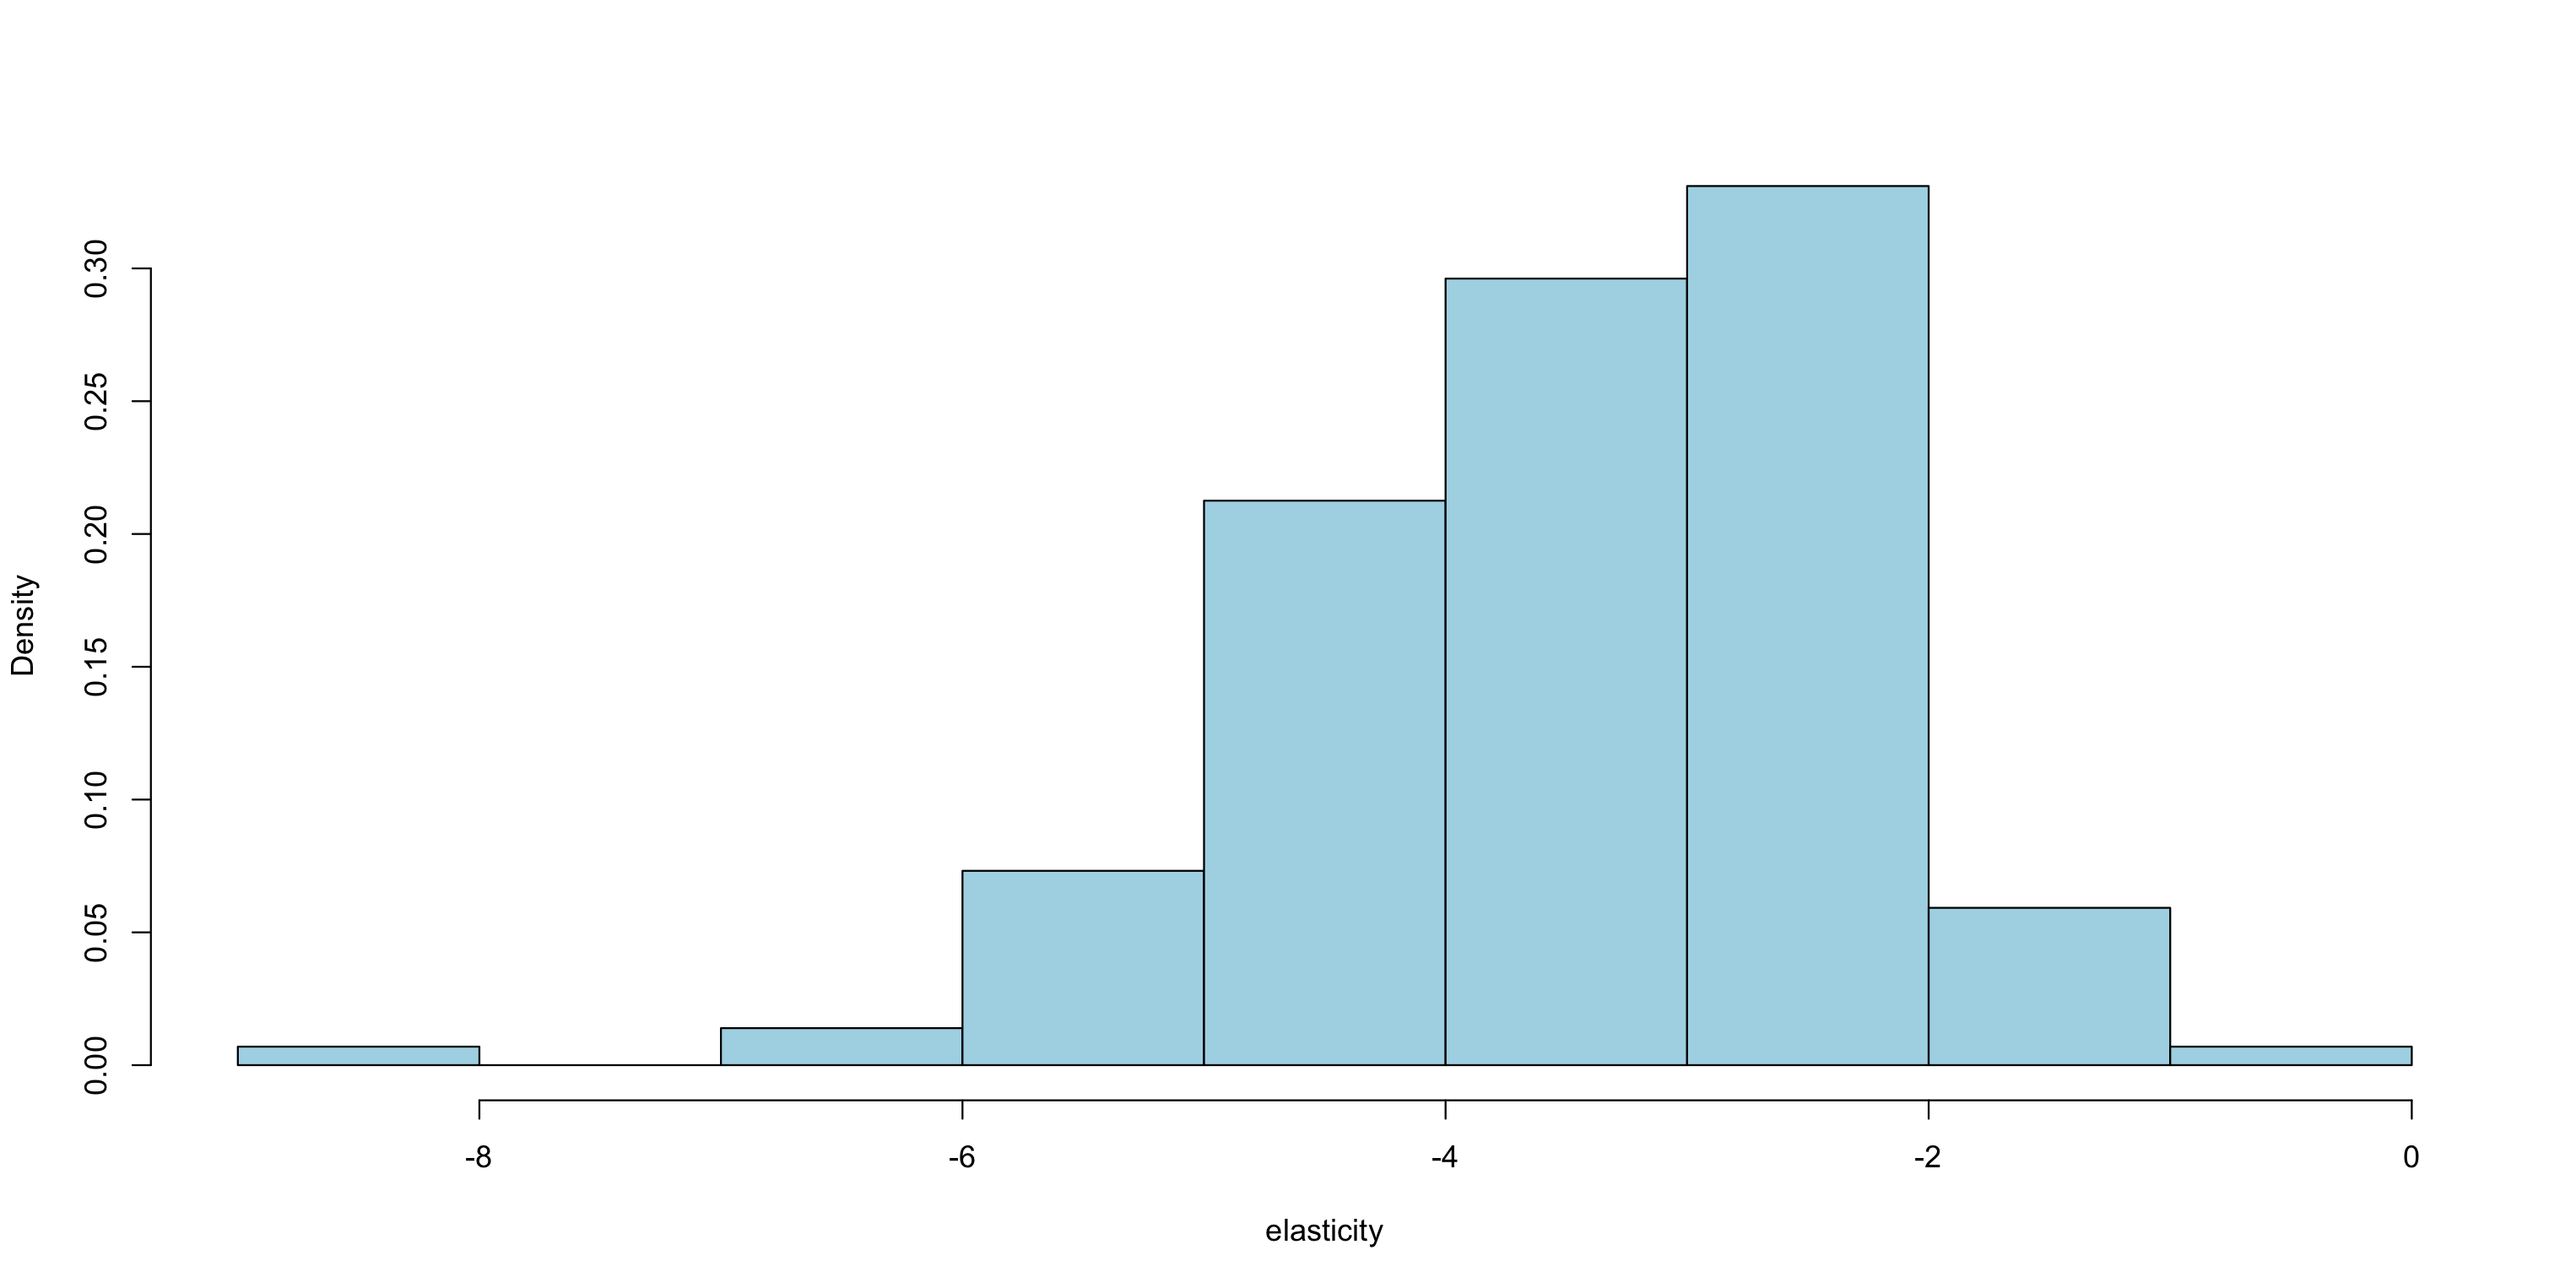

In [50]:
dmlhte <- gamlr(x=xhte[ss,]*resids$dtil, y=resids$ytil, free=1, standardize=FALSE)
coef(dmlhte)[1:2]
range( gamdml <- drop(eachbeer%*%coef(dmlhte)[-1,]) )
hist(gamdml, main="", xlab="elasticity", col="lightblue", freq=FALSE)

In [51]:
B <- coef(dmlhte)[-(1:2),]
B <- B[B!=0]
head(sort(round(B,2)))
head(sort(round(B,2), decreasing=TRUE))

bonus    lager     drft    draft longneck     30pk 
   -4.22    -3.04    -2.24    -1.44    -1.25    -1.19

sharp's     state      n.a.   schlitz       dry baderbrau 
     2.83      1.62      1.55      1.41      1.23      1.20

In [52]:
upc[names(sort(gamdml)[1:3]),]

,DESCRIP,OZ
,<chr>,<dbl>
7336097301,OLD STYLE LT BONUS 6 24pk,288
7336097305,OLD STYLE LT BONUS 6 24pk,288
3410015306,MILLER GENUINE DRFT 24pk,288


The other models performs much less sensibly with all these interactions, even the MLE that looked OK before.

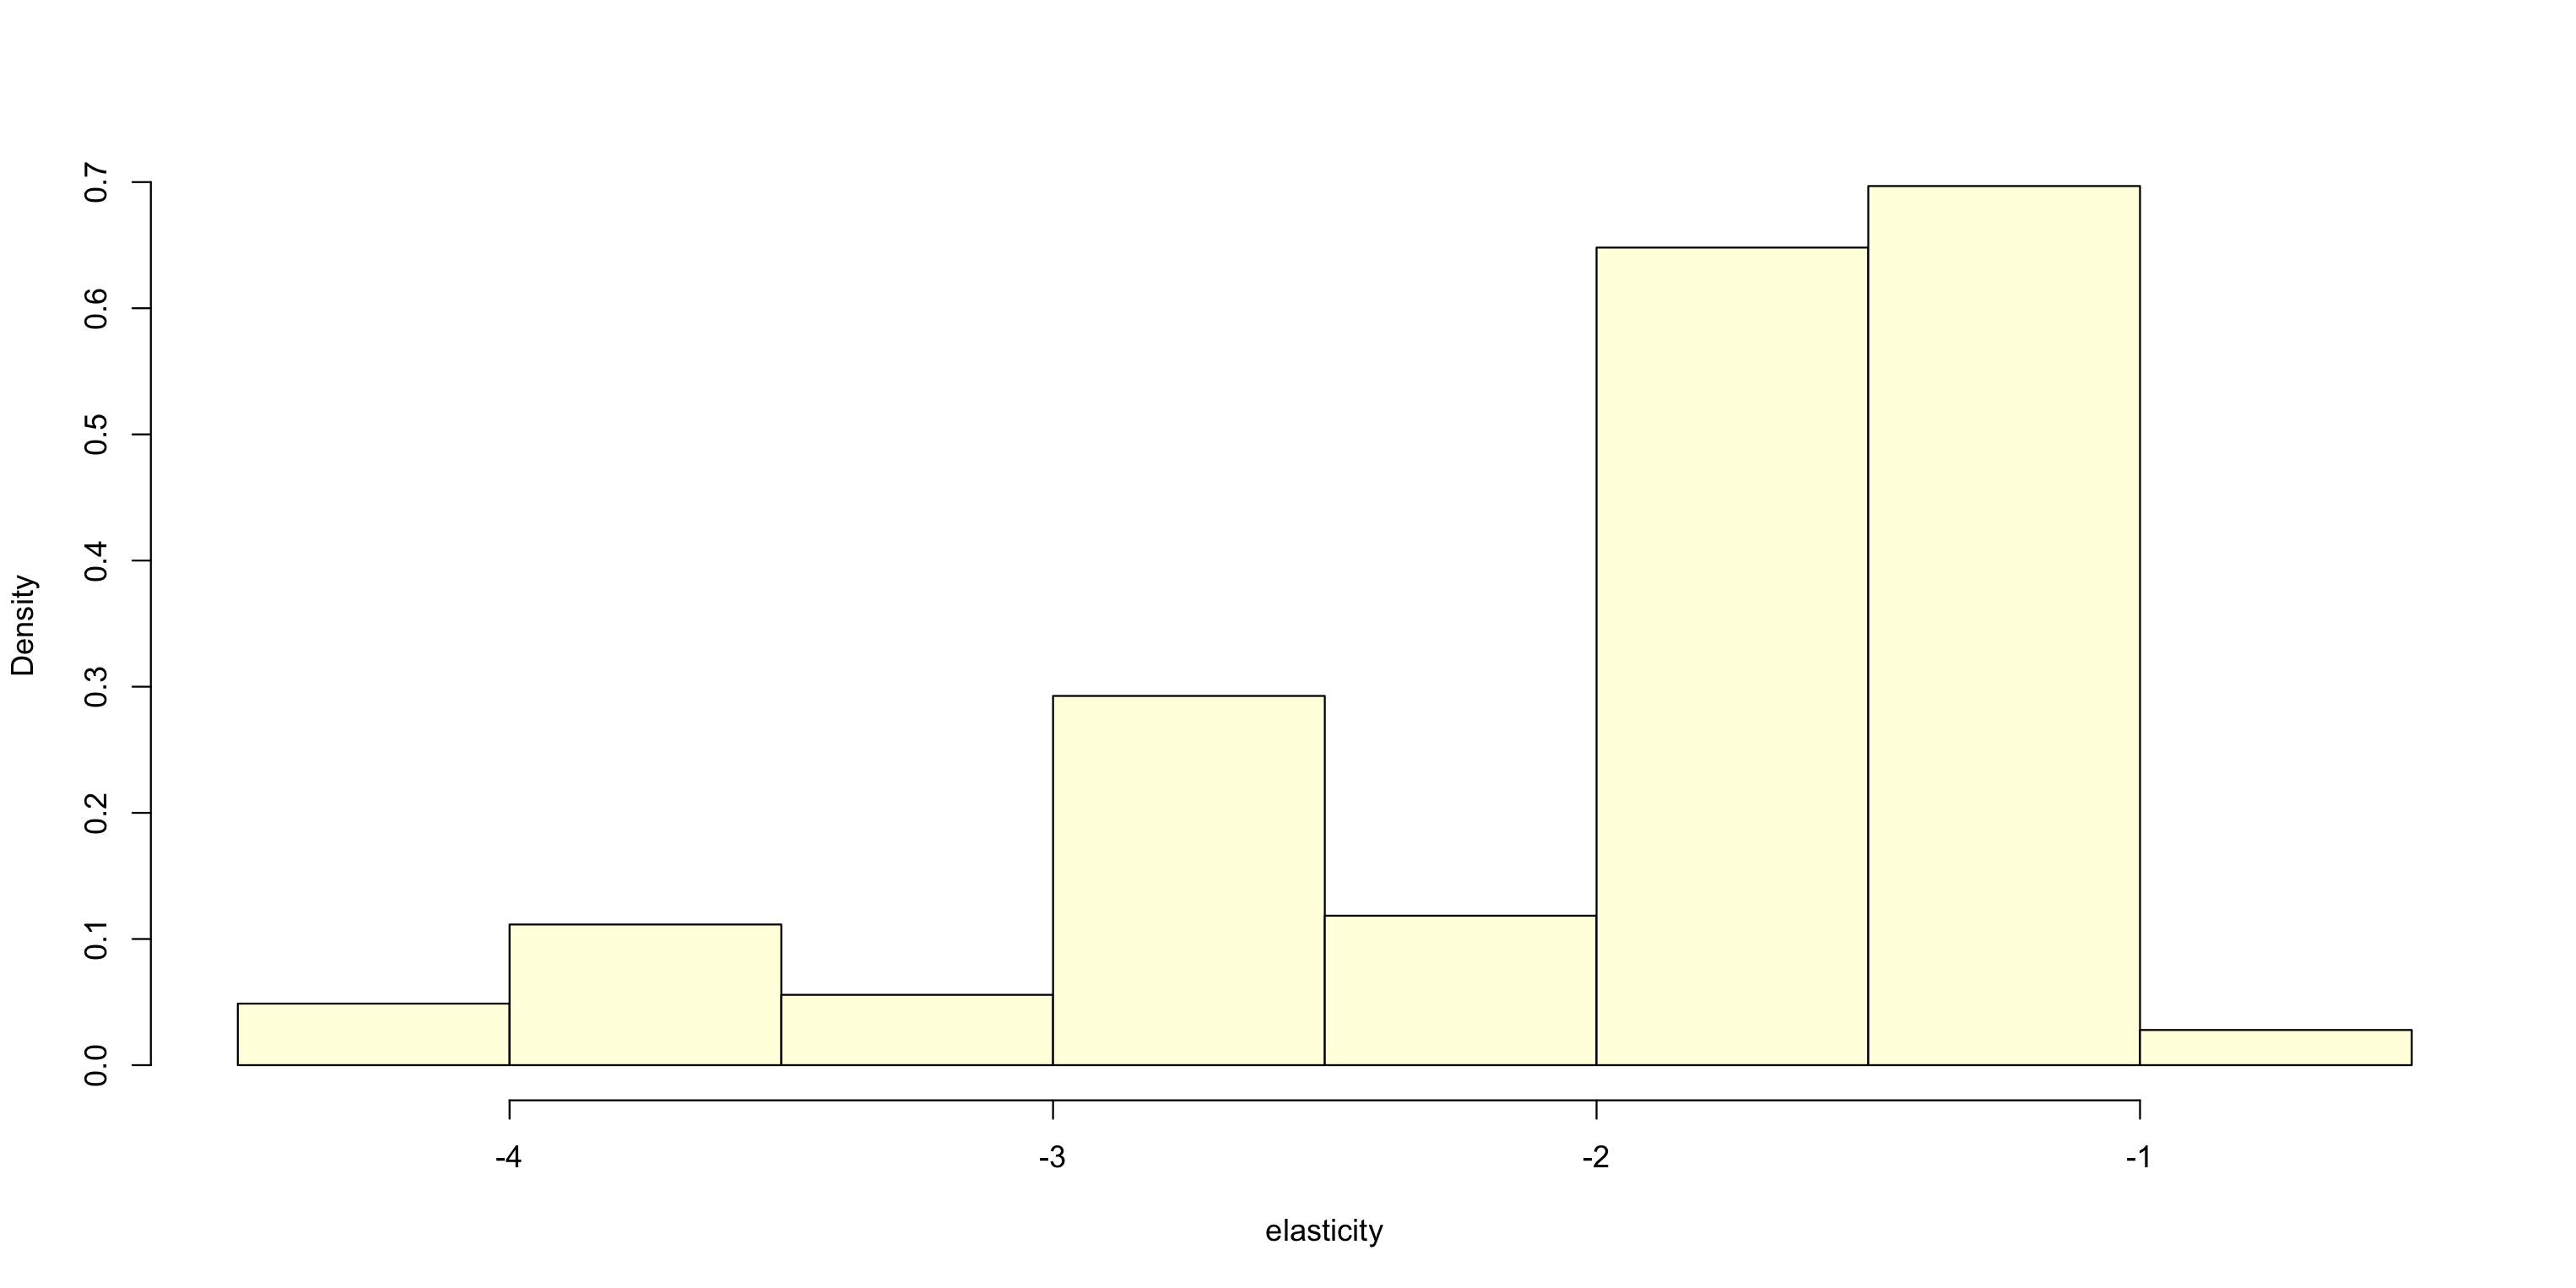

In [53]:
d <- xhte*wber$lp
colnames(d) <- paste("lp",colnames(d),sep=":")
naivehte <- gamlr(x=cbind(d,controls)[ss,], 
				  y=log(wber$MOVE)[ss], 
				  free=1, standardize=FALSE)
gamnaive <- drop(eachbeer%*%coef(naivehte)[2:(ncol(d)+1),])
hist(gamnaive, main="", xlab="elasticity", col="lightyellow", freq=FALSE)

73692011121  7336043668  8797501350  7336097301 
 -918.80920   -23.69548   -11.11589   -10.34126

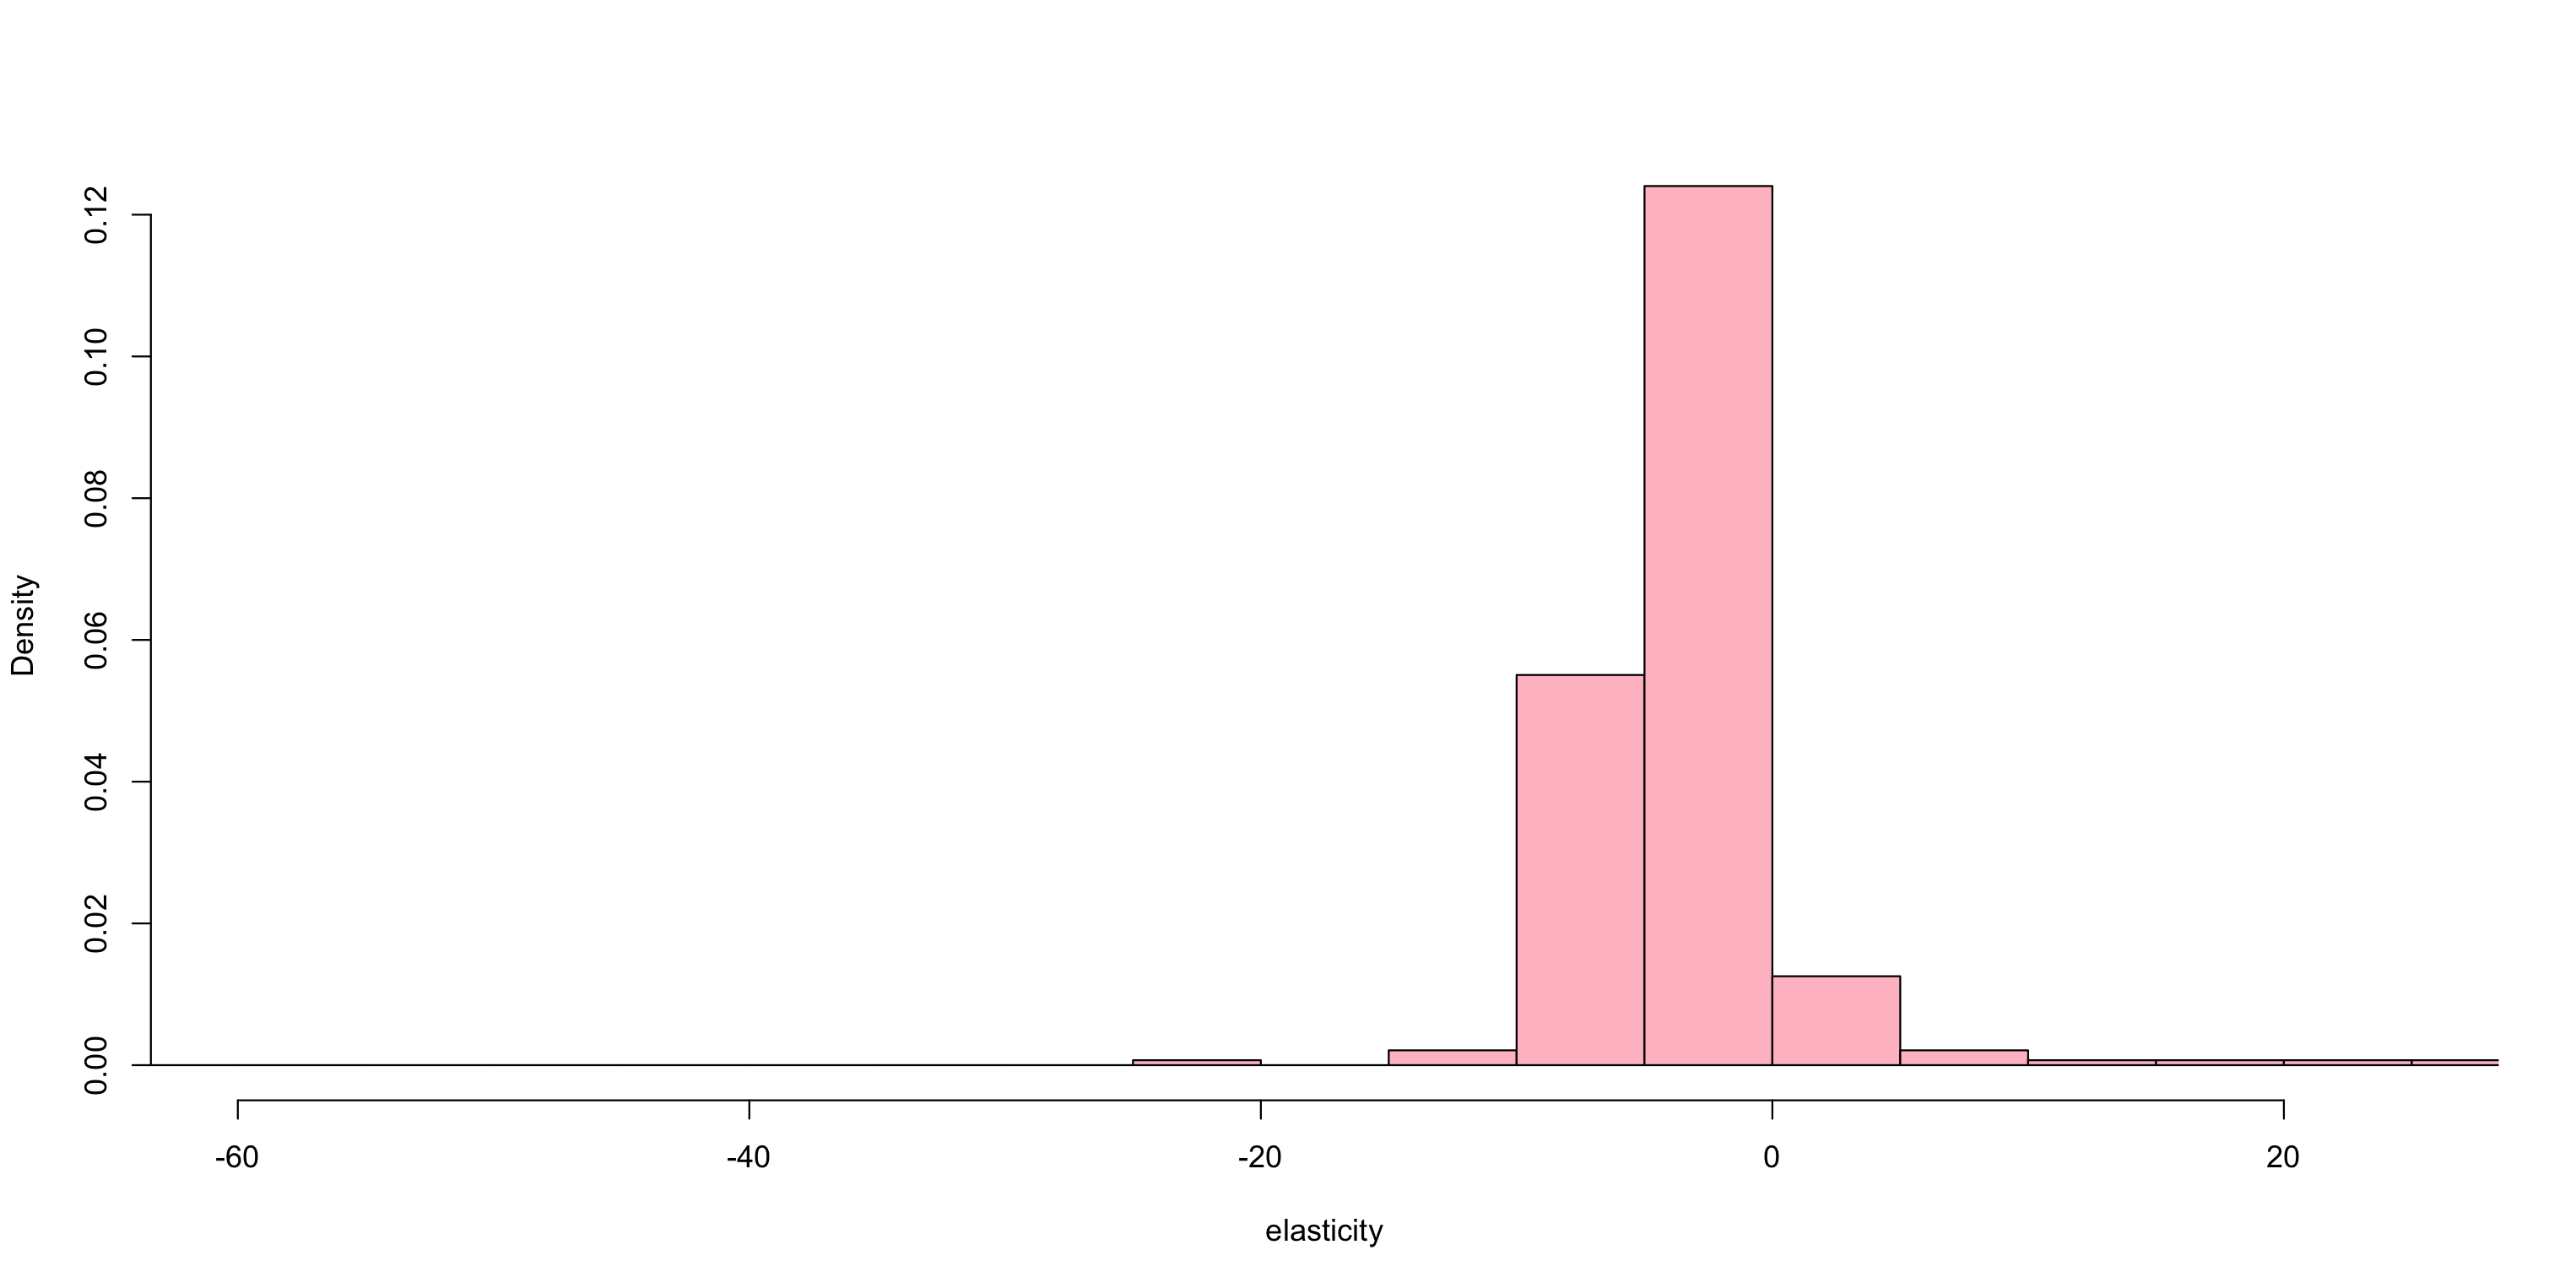

In [54]:
mlehte <- gamlr(x=cbind(d,controls)[ss,], 
	y=log(wber$MOVE)[ss], lambda.start=0)
gammle <- drop(eachbeer%*%coef(mlehte)[2:(ncol(d)+1),])
hist(gammle, main="", xlab="elasticity", breaks=200, col="pink", xlim=c(-60,25), freq=FALSE)
sort(gammle)[1:4]

If you use the entire data, even MLE could work (under ignorability):

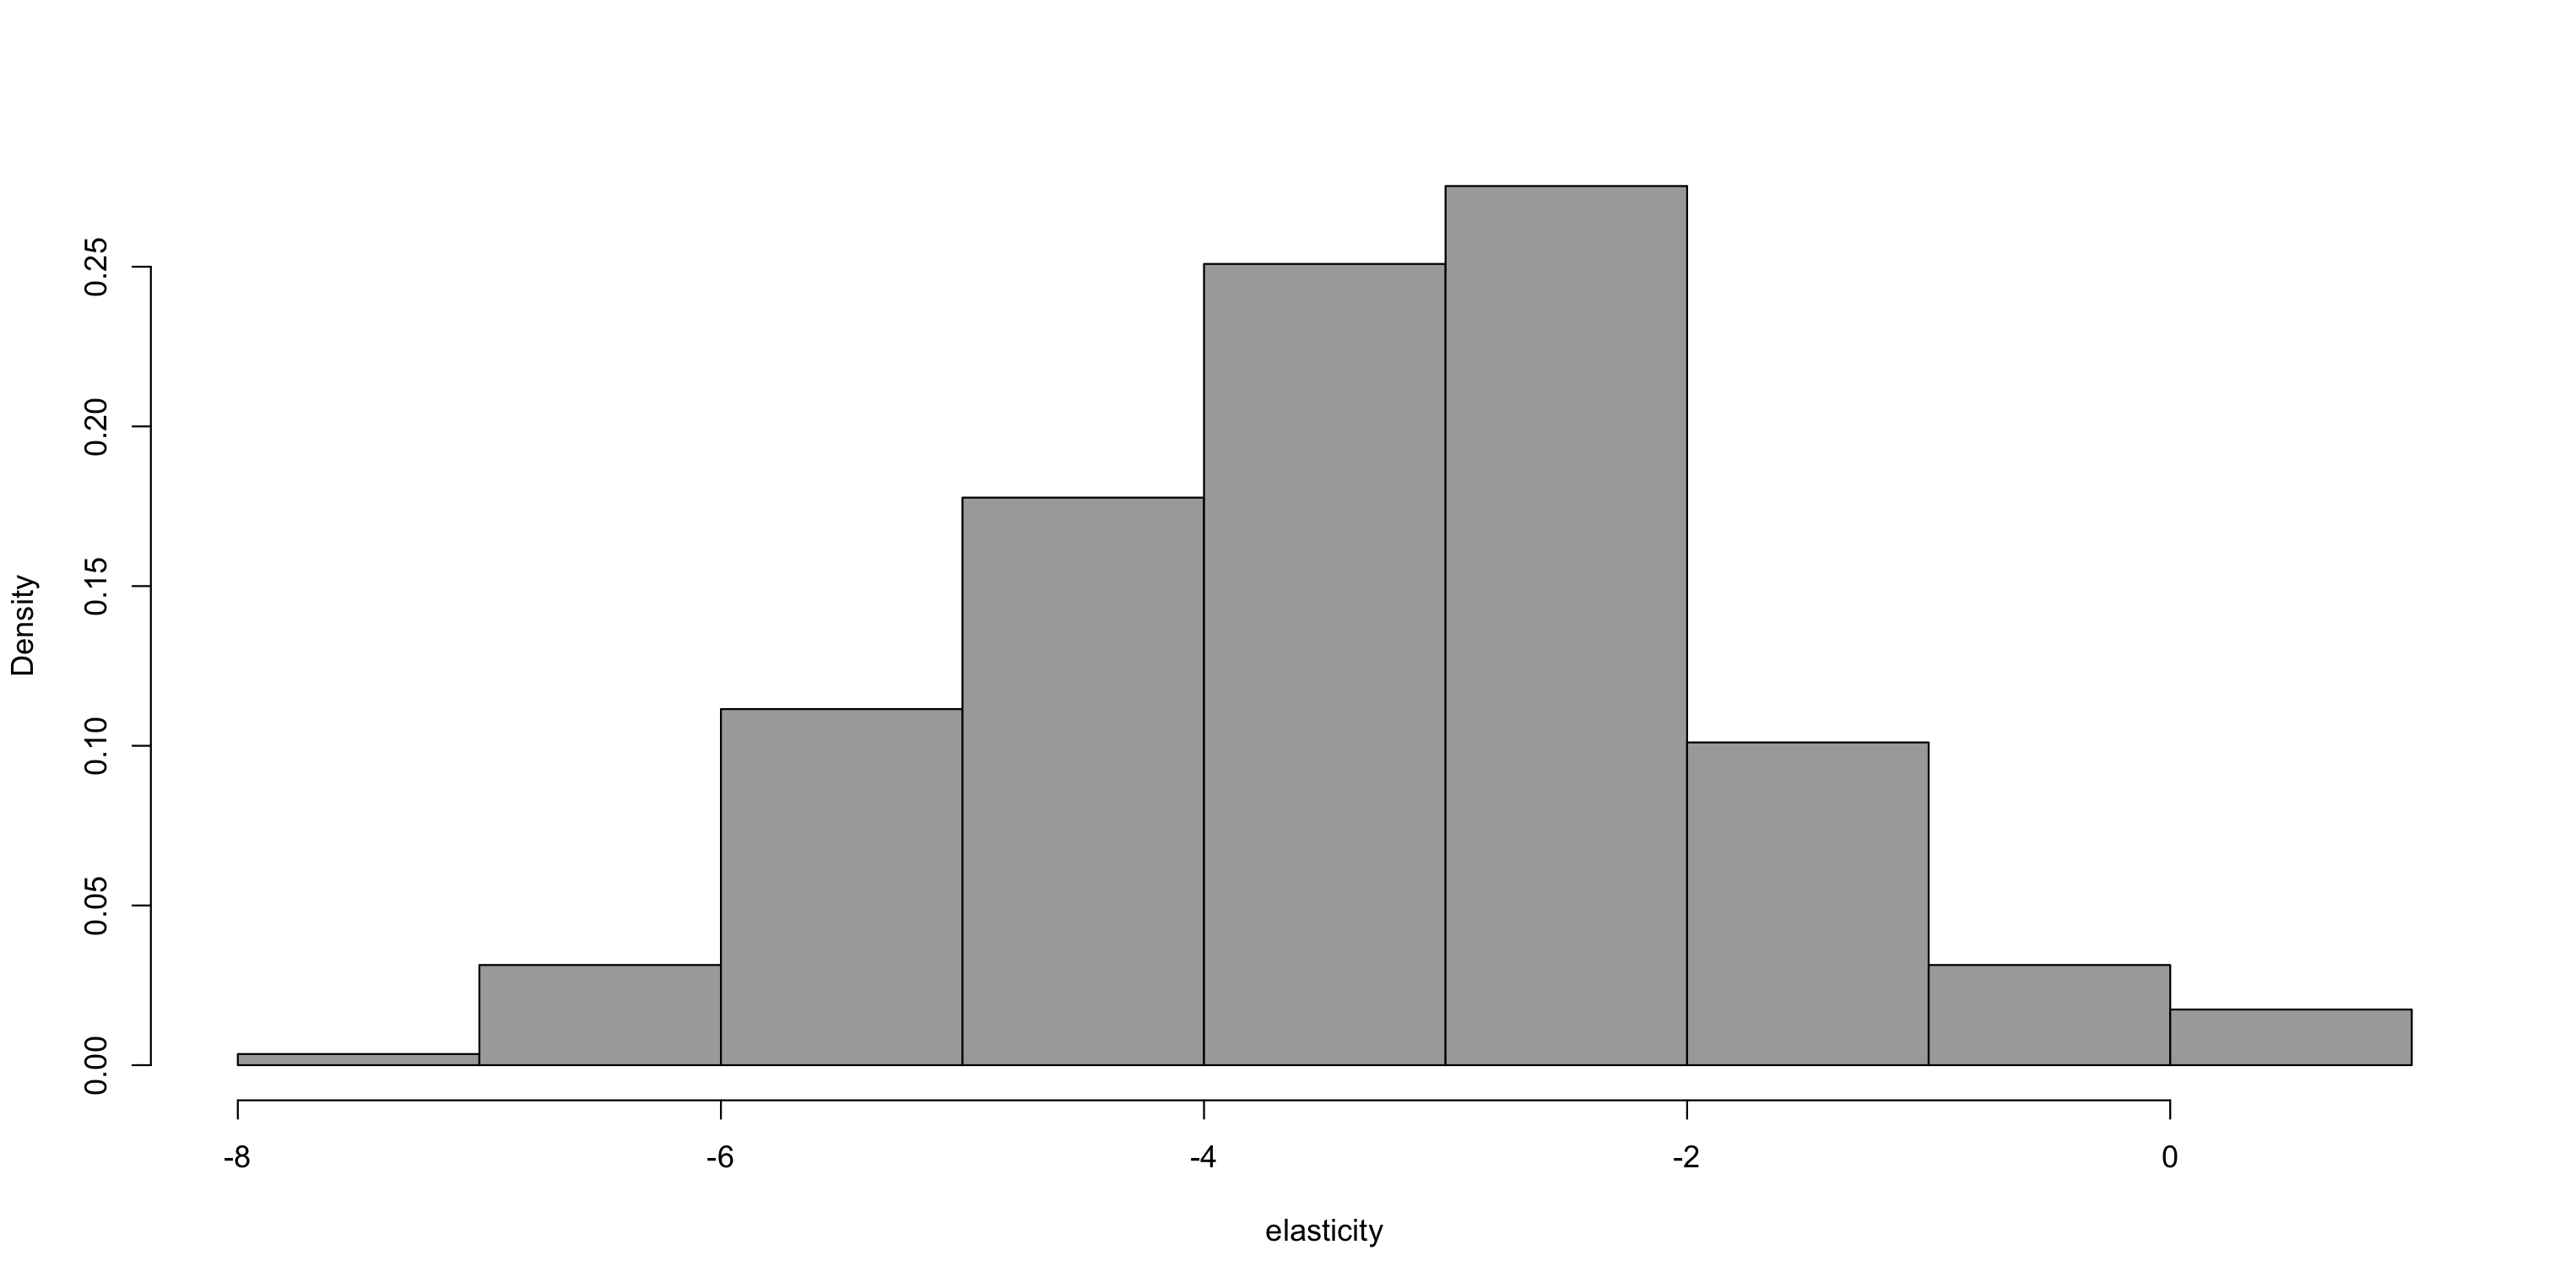

In [64]:
fullhte <- gamlr(x=cbind(d,controls), y=log(wber$MOVE), lambda.start=0)
gamfull <- drop(eachbeer%*%coef(fullhte)[2:(ncol(d)+1),])
hist(gamfull, main="", xlab="elasticity", ,
			 col="darkgrey", freq=FALSE)

But this is not a great sign:

In [56]:
upc[which(gamfull>0),]

,DESCRIP,OZ
,<chr>,<dbl>
3410000304,MILLER SHARP'S N/A C 6pk,72
3410010505,MILLER SHARP'S N/A L 6pk,72
5230000035,OLD MILWAUKEE N.A. C 6pk,72
5230001300,OLD MILWAUKEE N.A. B 6pk,72
5230001301,OLD MILWAUKEE N.A. B 6pk,72


Compare the elasticity estimates:

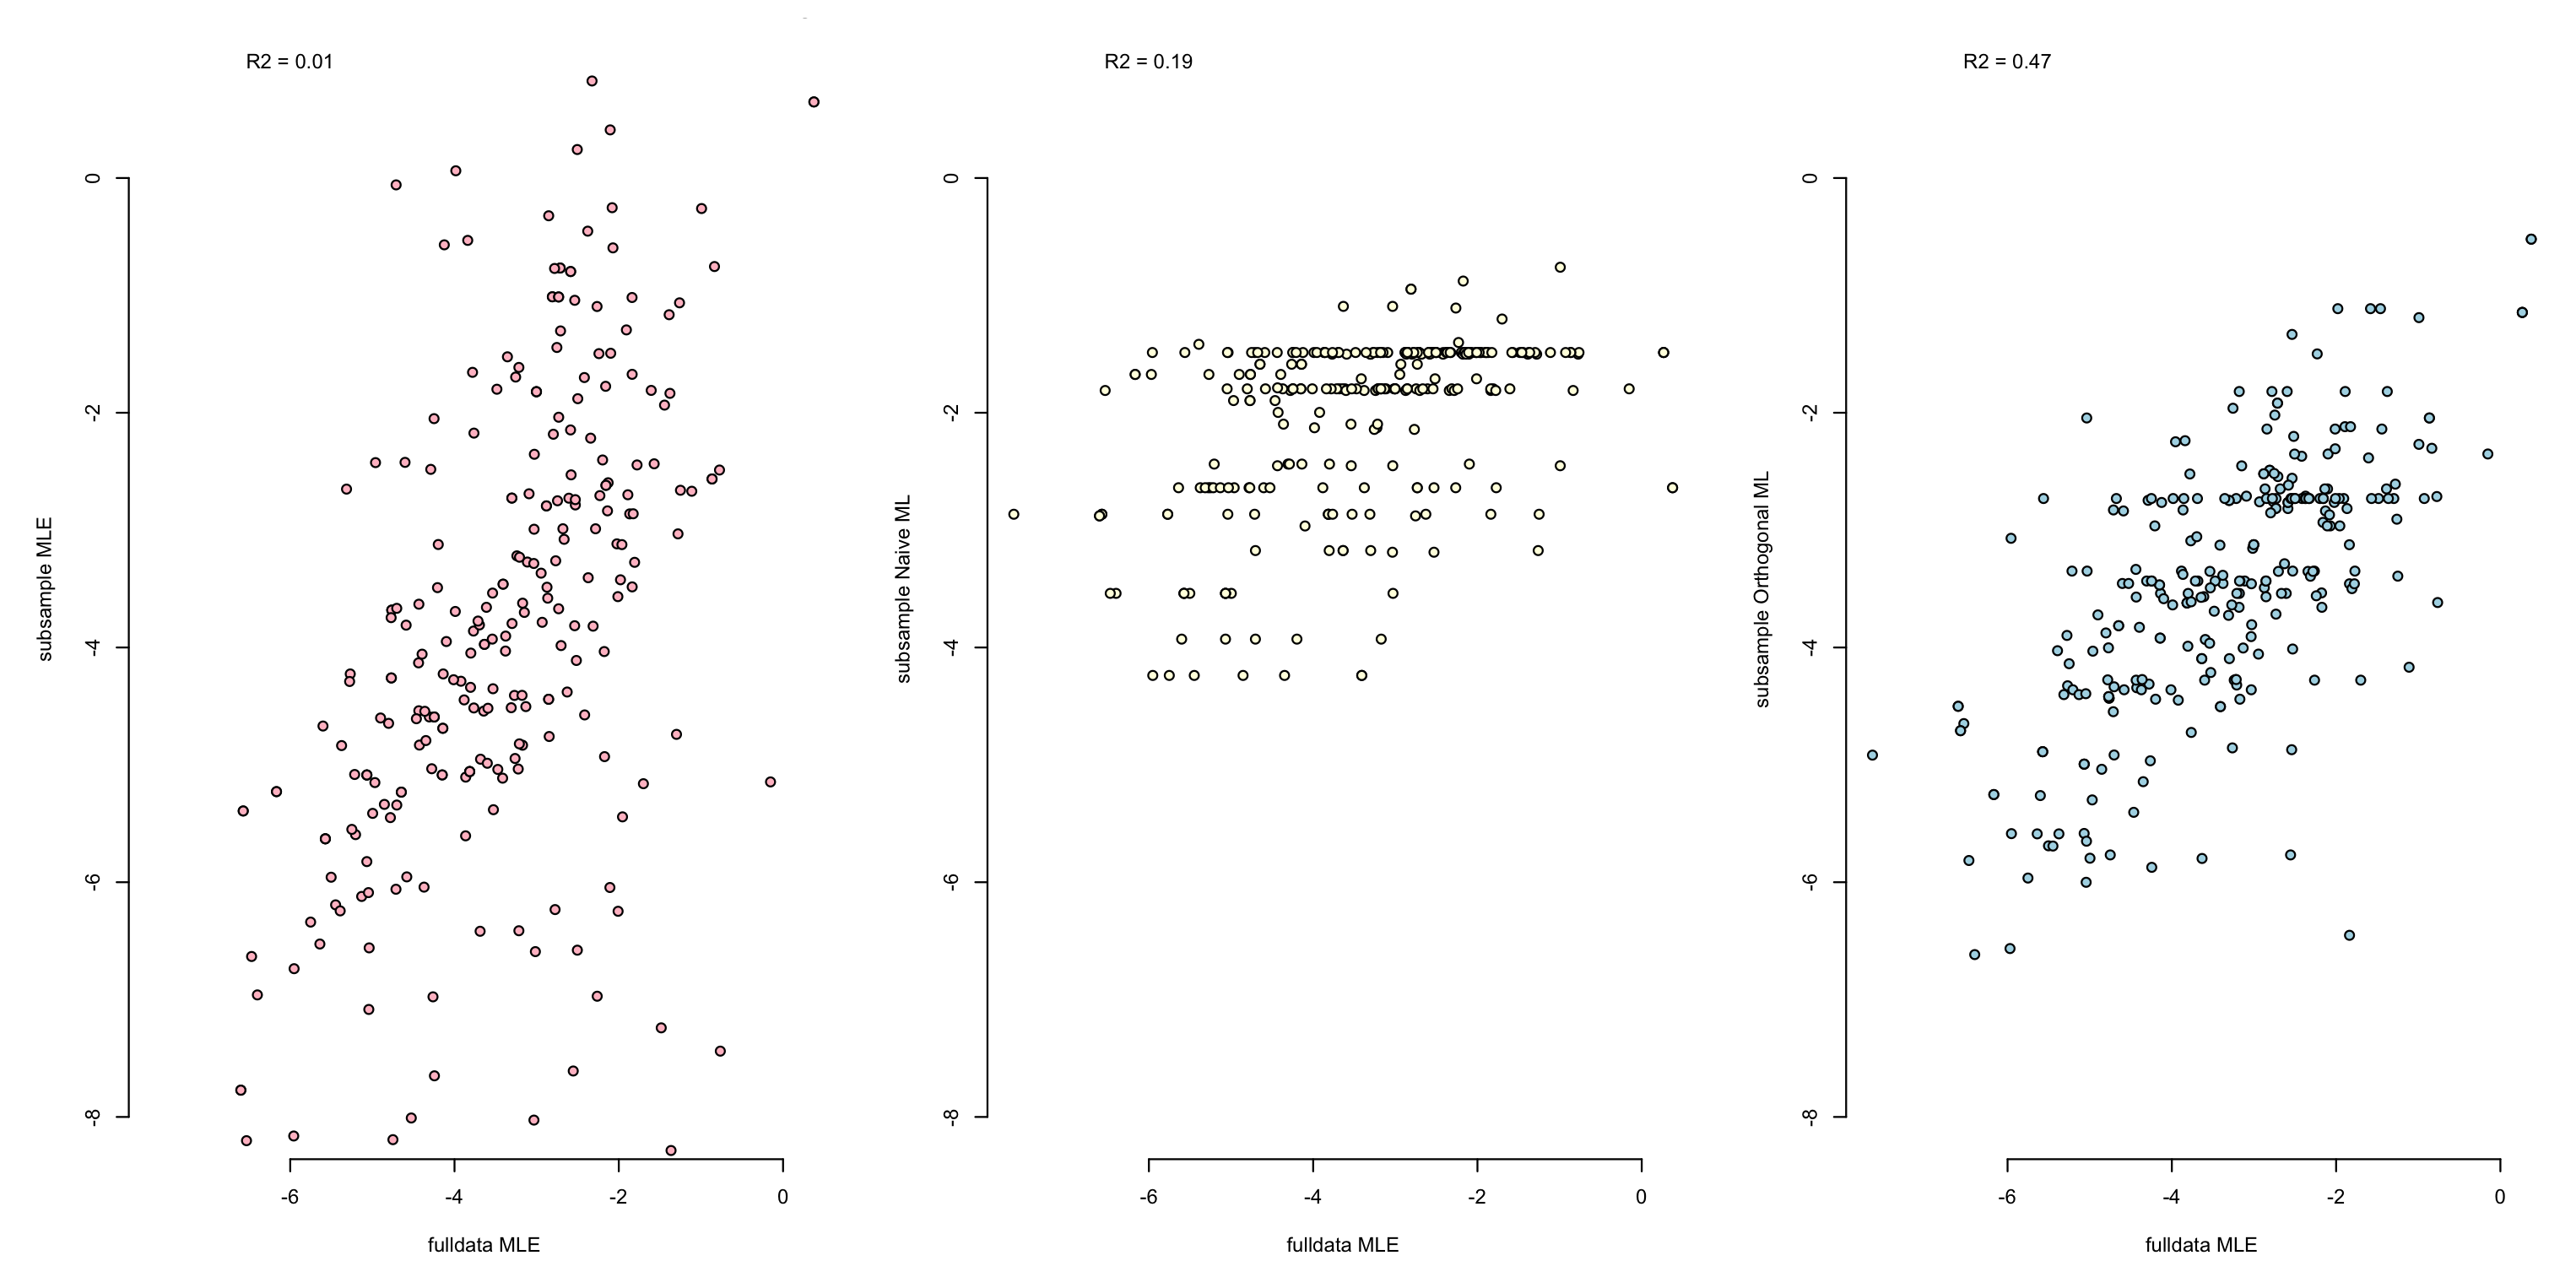

In [57]:
ylim <- c(-8,1)
par(mai=c(.7,.7,.1,.1), mfrow=c(1,3))
plot(gamfull, gammle, pch=21, bg="pink", xlab="fulldata MLE", ylab="subsample MLE", bty="n", ylim=ylim)
text(x=-6,y=1, sprintf("R2 = %.02f",summary(lm(gamfull~gammle))$r.squared))
plot(gamfull, gamnaive, pch=21, bg="lightyellow", xlab="fulldata MLE", ylab="subsample Naive ML", bty="n", ylim=ylim)
text(x=-6,y=1, sprintf("R2 = %.02f",summary(lm(gamfull~gamnaive))$r.squared))
plot(gamfull, gamdml, pch=21, bg="lightblue", xlab="fulldata MLE", ylab="subsample Orthogonal ML", bty="n", ylim=ylim)
text(x=-6,y=1, sprintf("R2 = %.02f",summary(lm(gamfull~gamdml))$r.squared))

# Synthetic controls

You are welcome to tune into the Chamberlain Seminar, by the way.

Just work with the OG data for this:

In [58]:
#install.packages(c("Synth","tidyr"))
library(Synth)
library(tidyr)
data(basque)

##
## Synth Package: Implements Synthetic Control Methods.


## See http://www.mit.edu/~jhainm/software.htm for additional information.




Attaching package: ‘tidyr’


The following object is masked _by_ ‘.GlobalEnv’:

    who


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack




Collect outcomes for treated region pre and post, and for all control.

In [59]:
y <- basque[,1:4] %>% spread(year, gdpcap)
rownames(y) <- y$regionname
y <- y[c(17,2:16,18), -(1:2)]
y <- y[,1:35]

We can define a function that runs an ML prediction routine to predict a control. This hard codes the treated year here.

In [60]:
library(gamlr)
synthc <- function(j, tyear=1968, ...){
	y0t <- t(y[,1:(tyear-1954)])
	fit <- gamlr( y0t[,-j], y0t[,j], ...)
	plot(fit)
	y0hat <- predict(fit, t(y[-j,]))[,1]
	return(list(w=coef(fit)[,1], y0hat=y0hat ) )
}

And run it.

intercept                    Andalucia 
                   0.8324923                    0.0000000 
                      Aragon       Principado De Asturias 
                   0.0000000                    0.0000000 
            Baleares (Islas)                     Canarias 
                  -0.1436622                    0.0000000 
                   Cantabria              Castilla Y Leon 
                   0.0000000                    0.5159924 
          Castilla-La Mancha                     Cataluna 
                   0.0000000                    0.0000000 
        Comunidad Valenciana                  Extremadura 
                  -0.3581780                    0.0000000 
                     Galicia        Madrid (Comunidad De) 
                   0.0000000                    0.4263979 
          Murcia (Region de) Navarra (Comunidad Foral De) 
                   0.8928448                    0.0000000 
                  Rioja (La) 
                   0.0000000

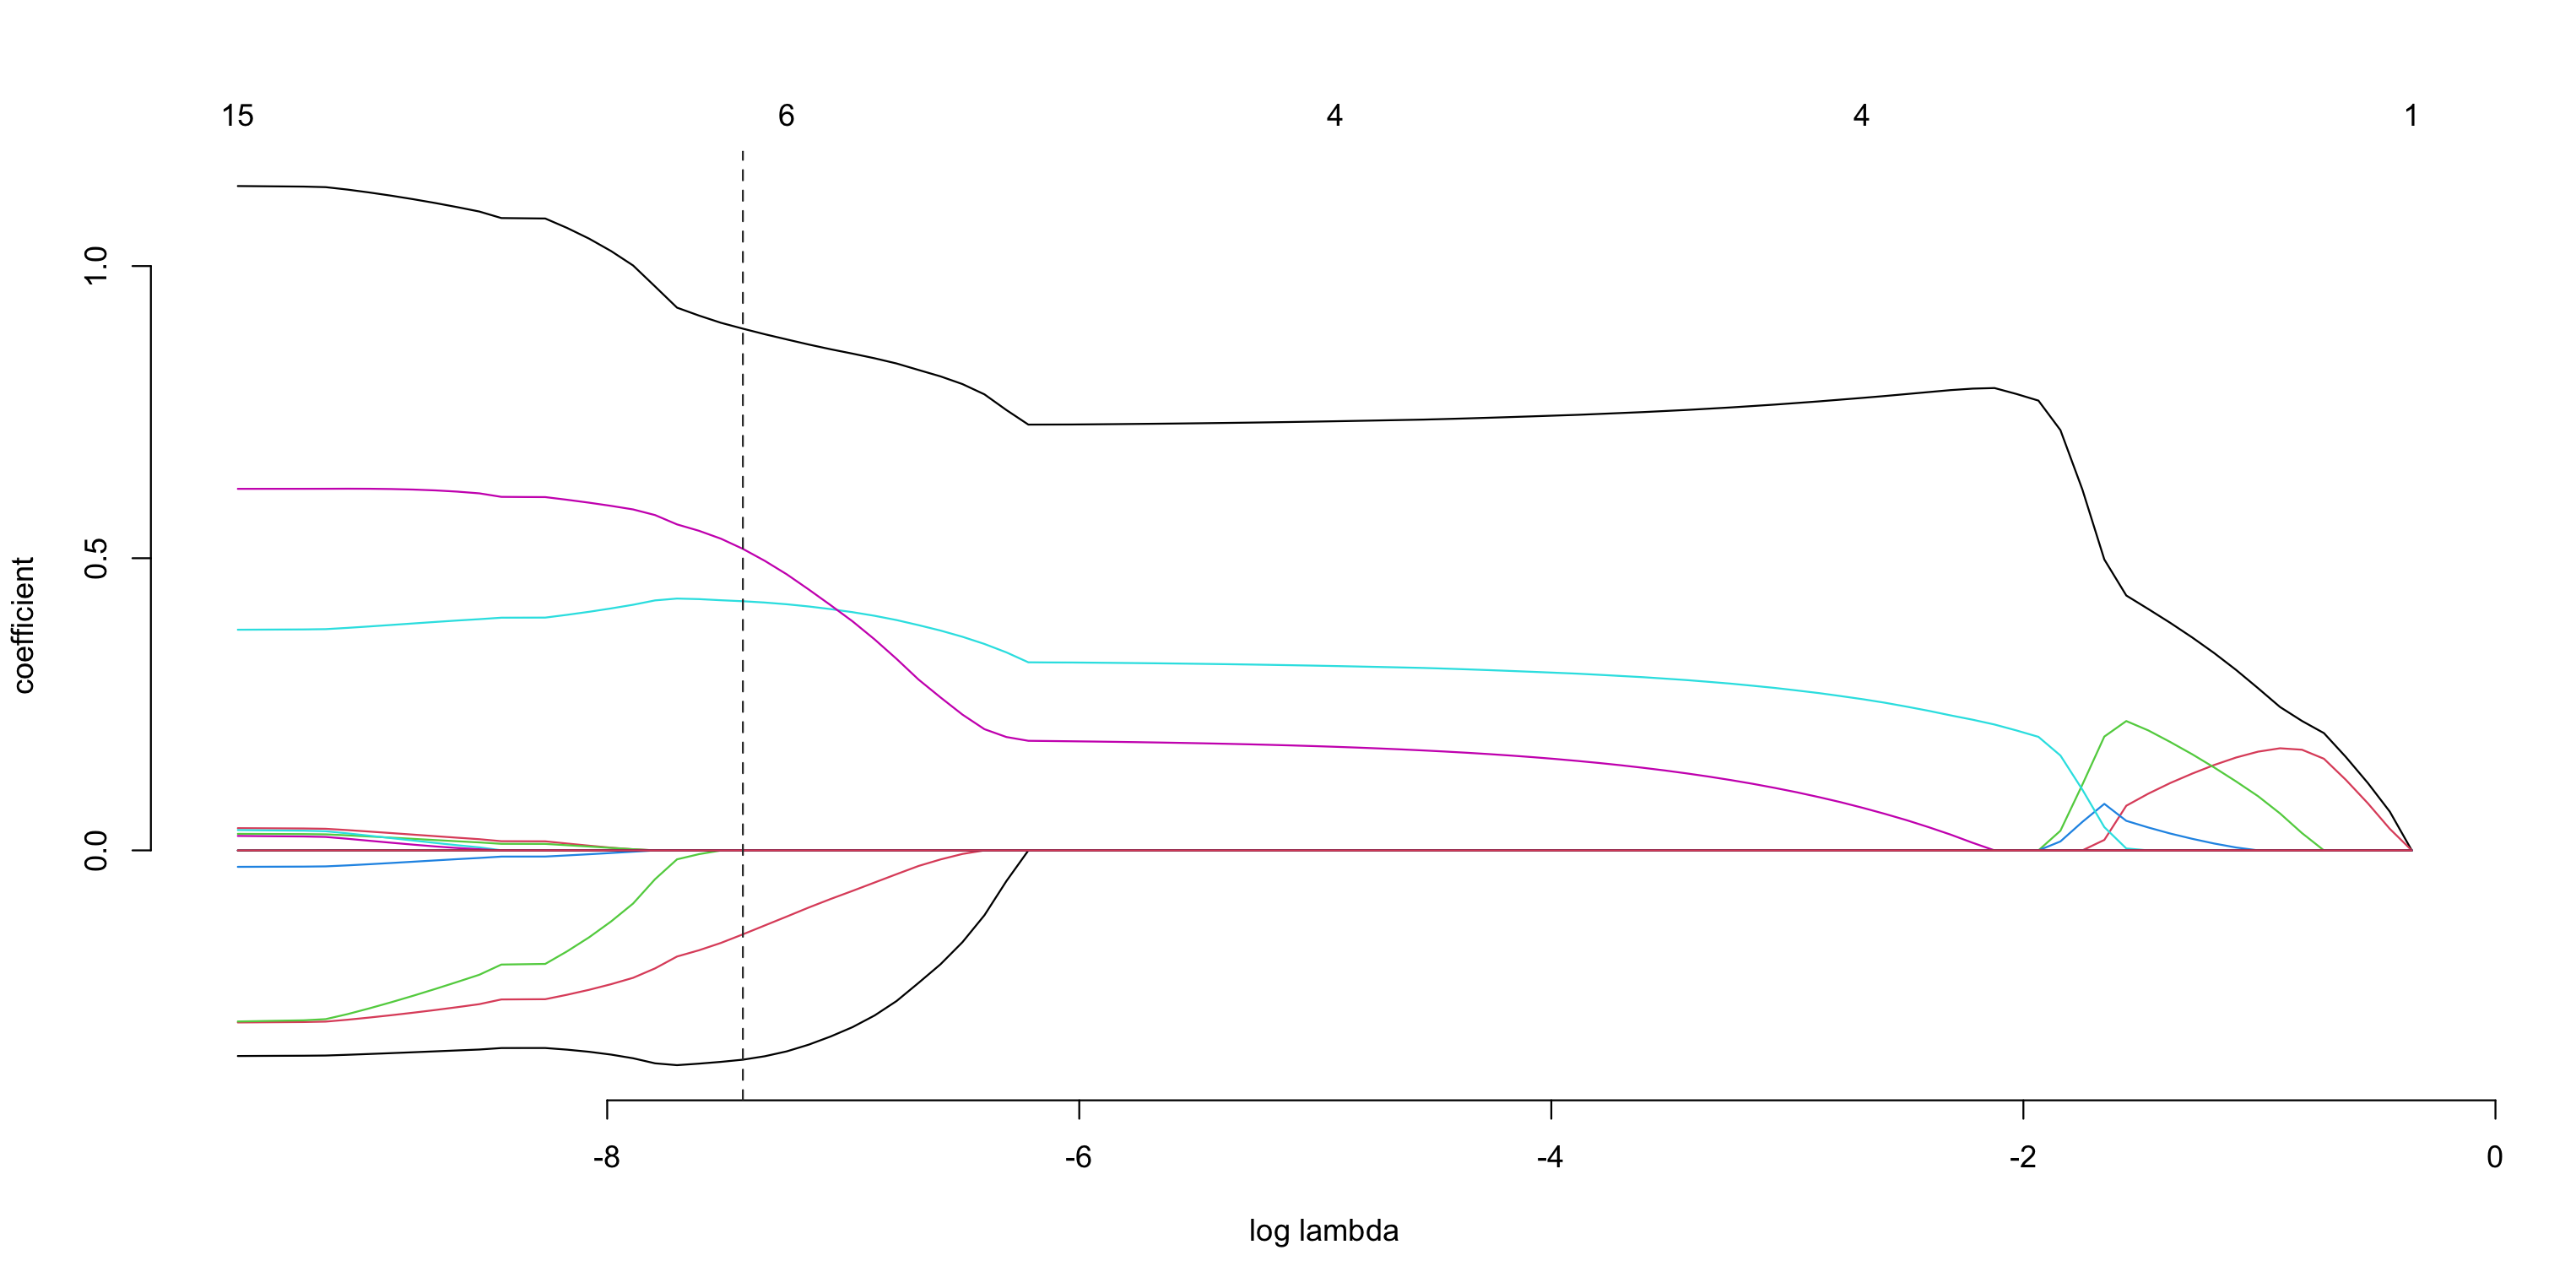

In [61]:
sc <- synthc(1, lmr=1e-4)
sc$w

We can do a permutation test for untreated regions, and this is typically a task that can be parallelized.

In [62]:
library(parallel)
cl <- makeCluster(detectCores())
clusterExport(cl, c("y", "gamlr", "synthc"))

gety0 <- function(j){ synthc(j, lmr=1e-4)$y0hat }
Ysynth <- parSapply(cl, 1:nrow(y), gety0)
diff <- Ysynth - t(y)

Aaaaand plots!

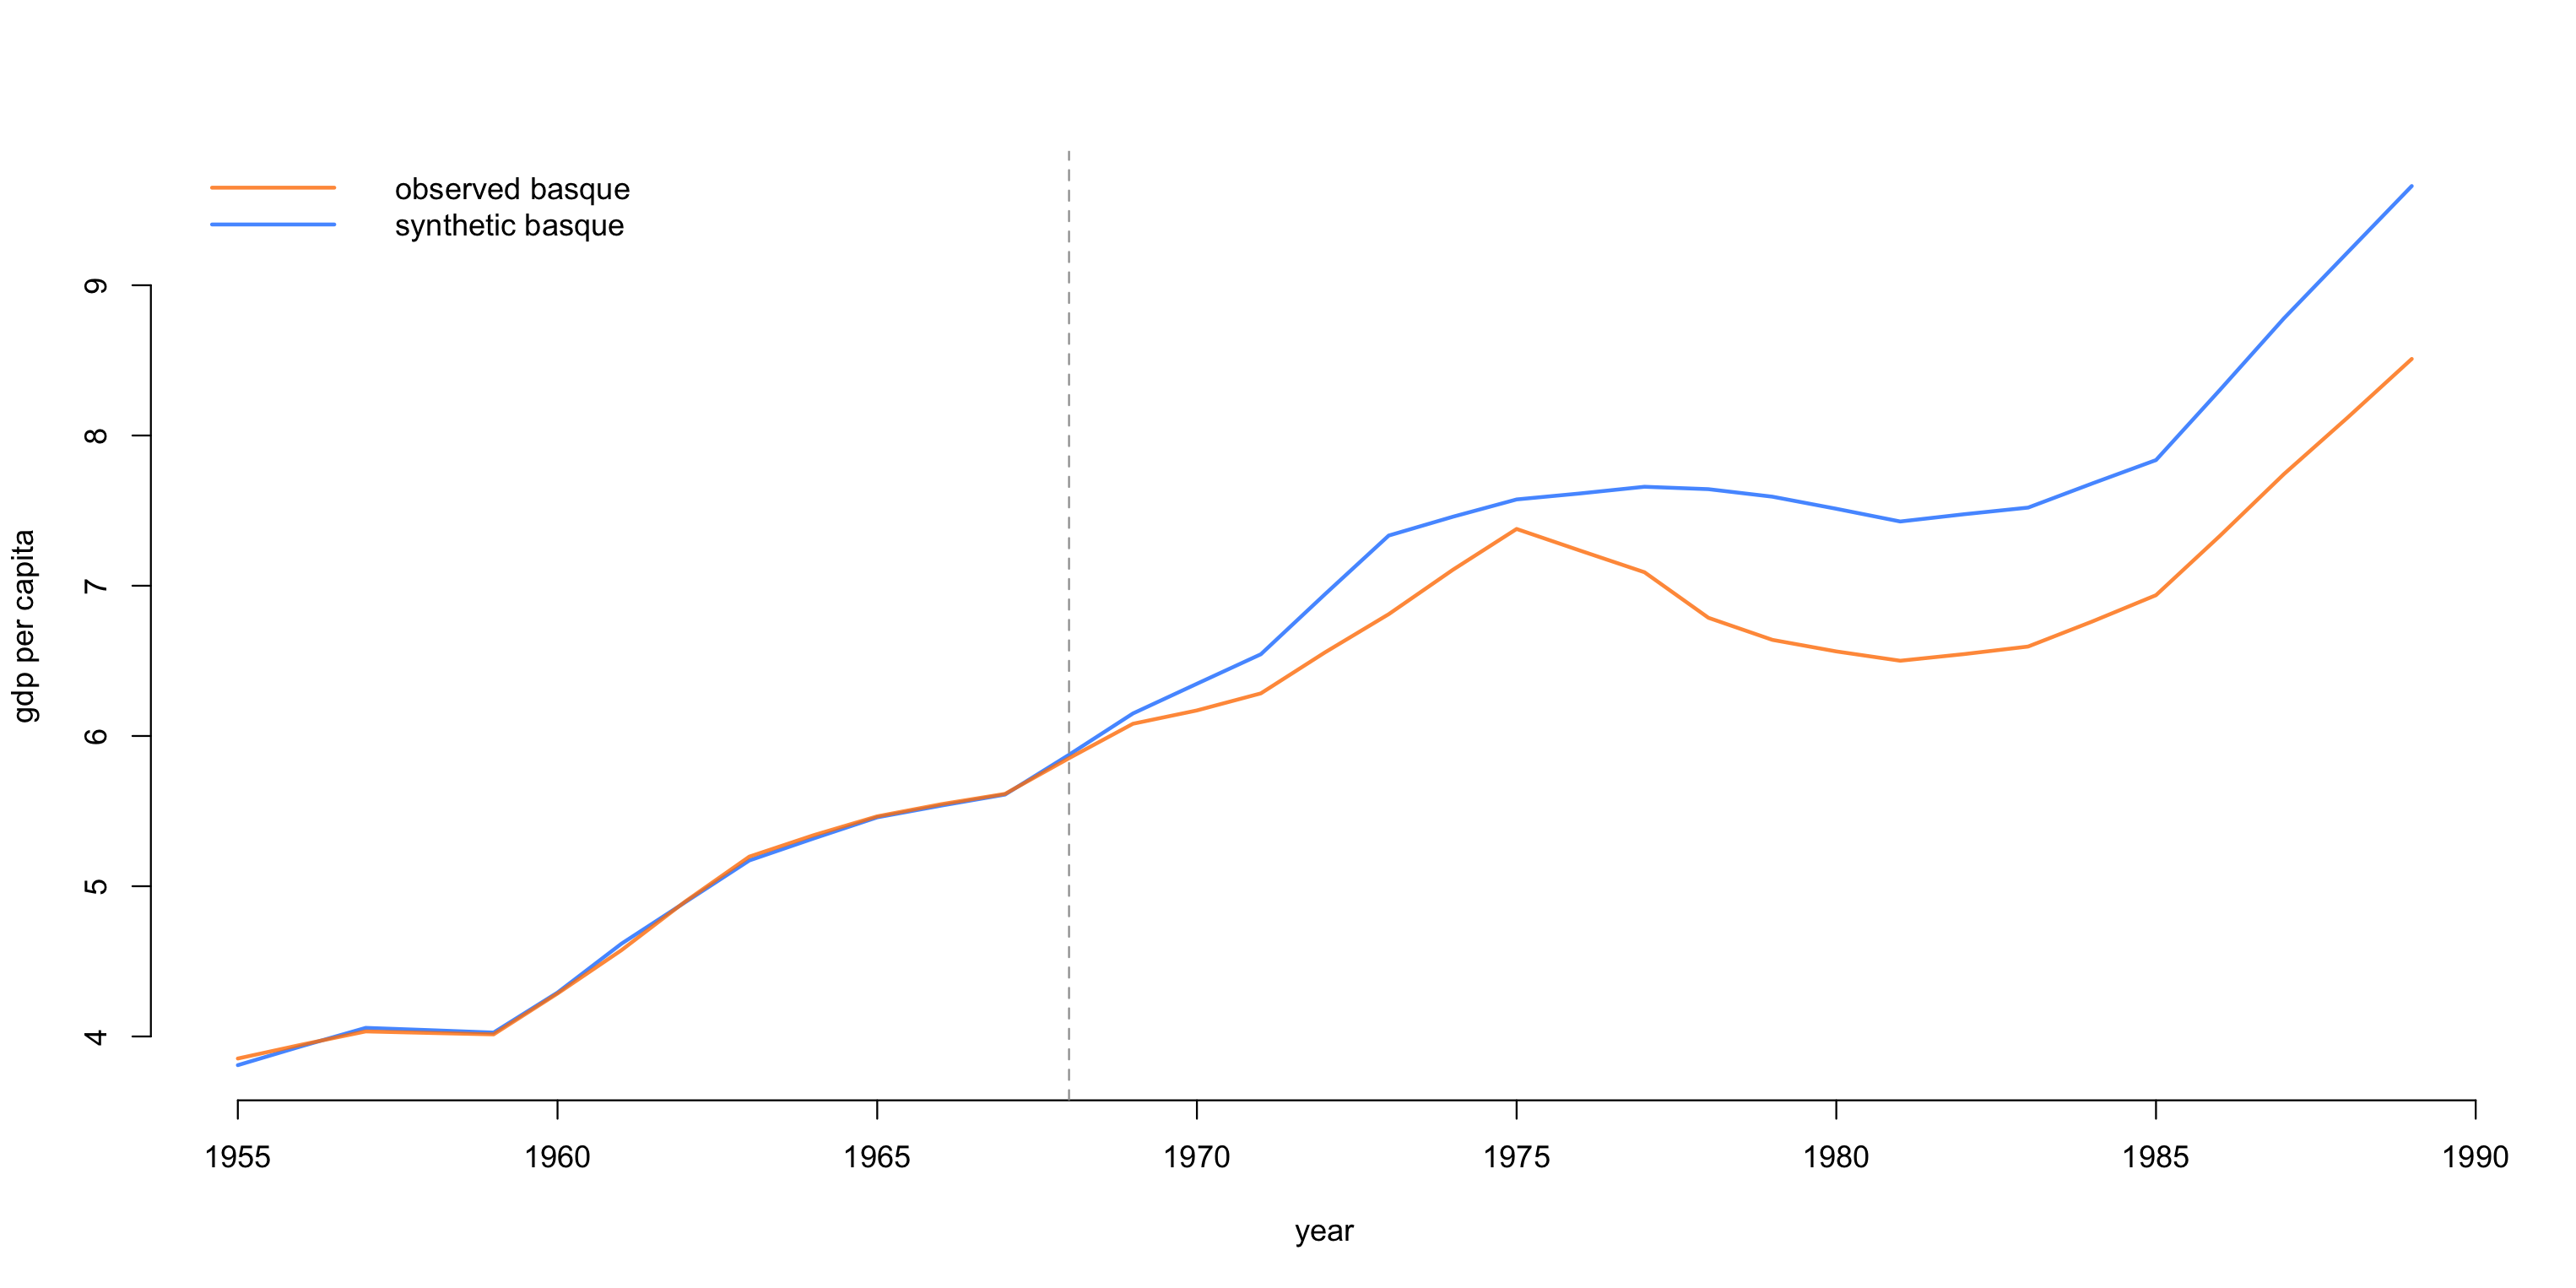

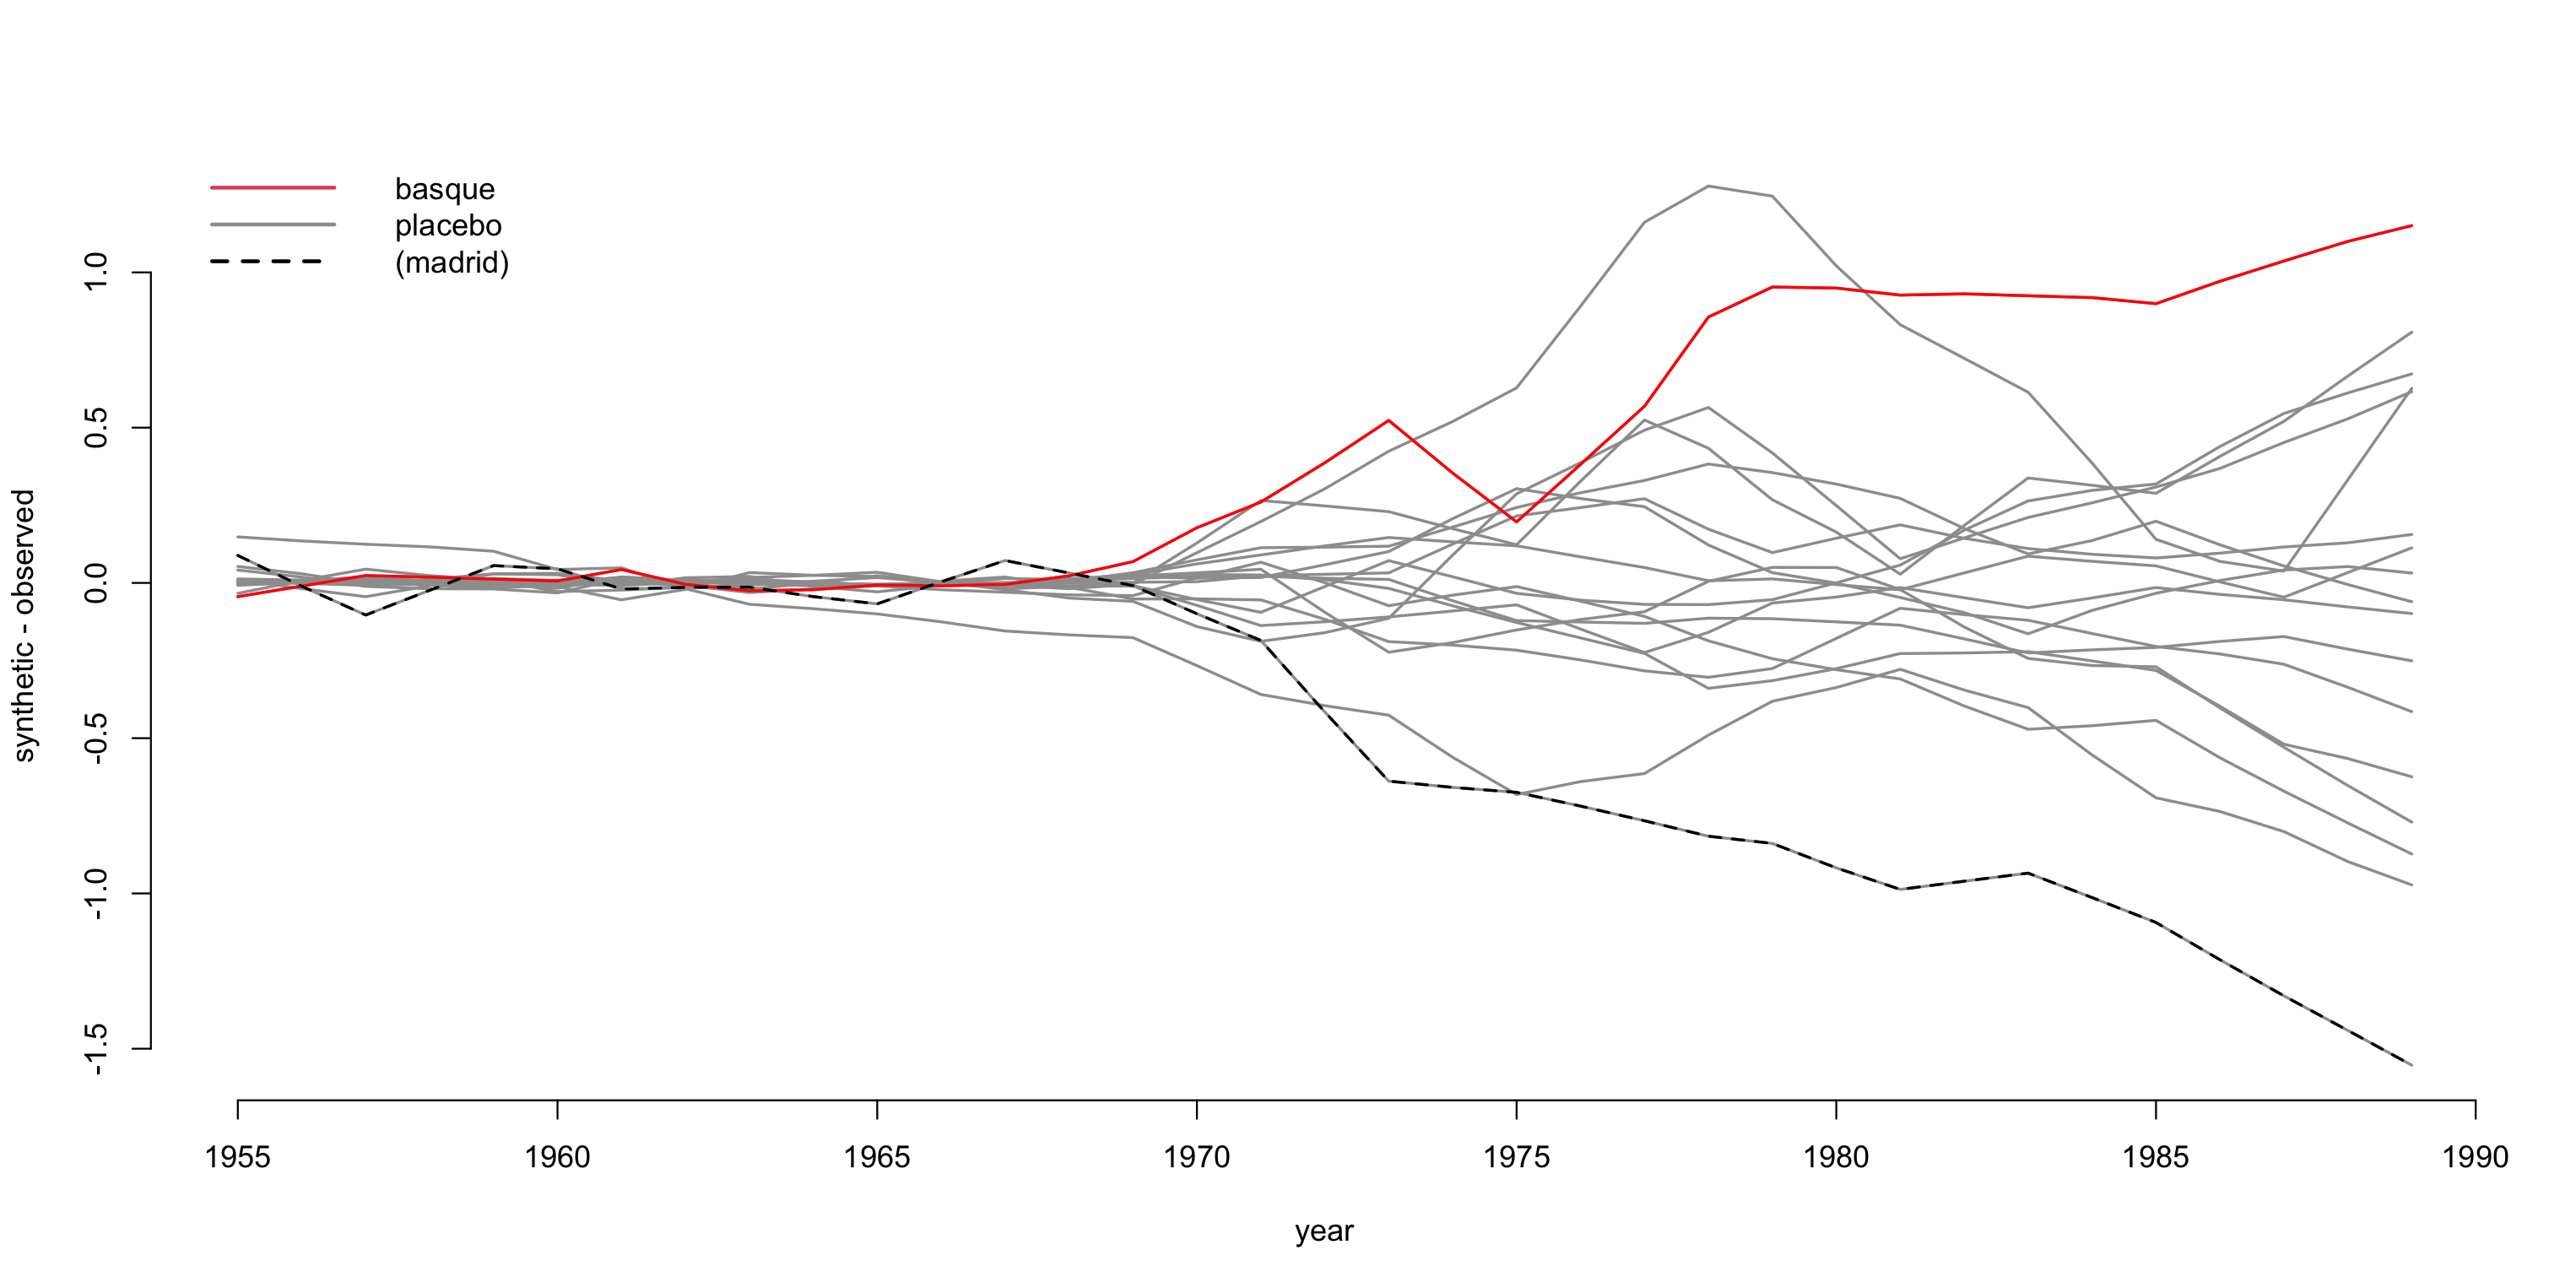

In [63]:
year <- as.numeric(colnames(y))
plot(year, sc$y0hat, type="l", ylab="gdp per capita",
	col=rgb(.1,.5,1,0.8), ylim=range(c(y[1,],sc$y0hat)), bty="n", lwd=2)
abline(v=1968, col=8, lty=2)
lines(year, y[1,], col=rgb(1,.5,0,.8), lwd=2)
legend("topleft", bty="n", legend=c("observed basque","synthetic basque"), 
	lwd=2, col=c(col=rgb(1,.5,0,.8),rgb(.1,.5,1,0.8)) )

matplot(year, diff, type="l", lwd=1.5, 
	xlab="year", ylab="synthetic - observed",
 	col=8, lty=1, bty="n")
lines(year, diff[,1], lwd=1.5, col="red")
lines(year, diff[,14], lwd=1.5, lty=2, col=1)
legend("topleft", bty="n", 
	legend=c("basque", "placebo", "(madrid)"), 
	lty=c(1,1,2), lwd=2, col=c(2,8,1))